In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import stim
import sys
sys.path.append('./cultiv_code/src')
sys.path.append('./rpdata')
from cultiv import ErrorEnumerationReport
from volume_calc import *
from csv_so_processor import *

cache_file = ErrorEnumerationReport.read_cache_file("./error_cache.txt")

In [170]:
import sys
import csv
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [171]:
single_qubit_gates = {"S_DAG","S","X","Y","Z","H"}
two_qubit_gates = {"CNOT", "CX", "CZ"}
measurement_gates = {"M", "MX", "MY", "MZ"}
reset_gates = {"R","RX", "RY", "RZ"}
mr_gates = {"MR", "MRX", "MRY", "MRZ"}
mixed_qubit_gates = single_qubit_gates | two_qubit_gates
mixed_gates_measurement = mixed_qubit_gates | measurement_gates
labels = {"DEPOLARIZE1", "DEPOLARIZE2", "X_ERROR", "Y_ERROR", "Z_ERROR","DETECTOR","QUBIT_COORDS","OBSERVABLE_INCLUDE","SHIFT_COORDS","E"}

type_gate_dict = {
    "single_qubit" : single_qubit_gates,
    "two_qubit" : two_qubit_gates,
    "measurement" : measurement_gates,
    "reset" : reset_gates,
    "mr" : mr_gates,
    "mixed_qubit" : mixed_qubit_gates,
    "mixed_qubit_measurement" : mixed_gates_measurement,
    "fully_mixed" : single_qubit_gates | two_qubit_gates | measurement_gates | reset_gates | mr_gates,
}

class CircuitAnalyzer:
    def __init__(self, circuit_or_path, final_rounds = 10):
        if isinstance(circuit_or_path, str):
            self.circuit = stim.Circuit.from_file(circuit_or_path).flattened()
        else:
            self.circuit = circuit_or_path.flattened()
        self.lines = []
        self.analyze_ticks()
        self.final_rounds = final_rounds
    
    def analyze_ticks(self):
        current_tick = set()
        for gate in self.circuit:
            if gate.name == 'TICK':
                for type, gates in type_gate_dict.items():
                    if current_tick.issubset(gates | labels):
                        self.lines.append(type)
                        current_tick = set()
                        break
                else:
                    if not current_tick.issubset(labels):
                        print(current_tick)
                    current_tick = set()
            else:
                current_tick.add(gate.name)
        
    def circuit_depth(self):
        return len(self.lines)
    
    def circuit_depth_mr(self):
        count = 0
        for line,next_line in zip(self.lines,self.lines[1:]):
            if line == "measurement" and next_line == "reset":
                count += 1
        return self.circuit_depth() - count
    
    def single_qubit_gate_count(self):
        return self.lines.count("single_qubit")
    
    def standardized_depth(self, rounds = 10):
        return self.circuit_depth_mr() - self.single_qubit_gate_count() + 5 * (rounds - self.final_rounds)
    
    def standardized_volume(self):
        return self.standardized_depth() * self.circuit.num_qubits


In [172]:
gap_handler = Gap(pathdir = './rpdata/msc_paper_results/')
gap_handler.read_through_custom_counts()
gap_handler.read_through_vol_stats()


d_rp3 = 3
d_sc = 7
rp3_name = 'rp' + str(d_rp3)
sc_name = 'sc' + str(d_sc)
n_rounds_d3 = d_rp3 

filename_d3_e2e = 'rp_' + str(d_rp3) + '_sc_' + str(d_sc) + '_end2end_' \
                + str(n_rounds_d3+1) + '_full_rds' + '_so2d'
d3_end2end_res = SO_2d(filename_d3_e2e, './rpdata/sample_results/')
d3_end2end_res.read_through_custom_counts()

filename_d3_circ = 'rp_3_sc_7_end2end_4_full_rds'
circ_path = './rpdata/circuit_garage/' + filename_d3_circ + '.stim'
discard_res_path = './rpdata/sample_results/' + 'rp_3_T_cult' + '_combined.csv'


d3_vol_helper = Circ_rp3_T_end2end(circ_path,d_sc,n_rounds_d3)
d3_vol_helper.config_stages()
d3_vol_helper.active_qubits_calc()
d3_vol_helper.load_from_discard_tests(discard_res_path)


d_rp3 = 3
d_rp5 = 5
d_sc = 11
rp3_name = 'rp' + str(d_rp3)
rp5_name = 'rp' + str(d_rp5)
sc_name = 'sc' + str(d_sc)
n_rounds_d5 = d_rp5 
filename_d5_e2e = 'rp_' + str(d_rp3) \
                + '_rp_' + str(d_rp5) \
                + '_sc_' + str(d_sc) + '_end2end_' \
                + str(n_rounds_d5+1) + '_full_rds' + '_so2d'

d5_end2end_res = SO_2d(filename_d5_e2e, pathdir = './rpdata/sample_results/')
d5_end2end_res.read_through_custom_counts()

filename_d5_circ = 'rp_3_rp_5_sc_11_end2end_6_full_rds'
circ_path_d5 = './rpdata/circuit_garage/' + filename_d5_circ + '.stim'
discard_res_path_d5 = './rpdata/sample_results/' + 'rp_3_rp_5_T_cult' + '_combined.csv'


d5_vol_helper = Circ_rp5_T_end2end(circ_path_d5,d_sc,n_rounds_d5)
d5_vol_helper.config_stages()
d5_vol_helper.active_qubits_calc()
d5_vol_helper.load_from_discard_tests(discard_res_path_d5)



d3_retry_arr_2d = 1/((d3_end2end_res.c_geq_mono_and_gap_arr 
                + d3_end2end_res.e_geq_mono_and_gap_arr)/d3_end2end_res.shots)
d3_err_rates_arr_2d = d3_end2end_res.e_geq_mono_and_gap_arr/(
                        d3_end2end_res.c_geq_mono_and_gap_arr + 
                        d3_end2end_res.e_geq_mono_and_gap_arr)
d3_hits_1d = np.reshape(d3_end2end_res.e_geq_mono_and_gap_arr,(-1)).astype(np.int64)
d3_shots_1d = np.reshape(d3_end2end_res.e_geq_mono_and_gap_arr 
                      + d3_end2end_res.c_geq_mono_and_gap_arr,(-1)).astype(np.int64)

# get best trade-off indices:
d3_retry_arr_100 = np.round((100*np.reshape(d3_retry_arr_2d,(-1)))).astype(np.int64)

d3_retry_arr_1d = np.reshape(d3_retry_arr_2d,(-1))
d3_err_rates_arr_1d = np.reshape(d3_err_rates_arr_2d,(-1))

d3_best_indices = []
d3_retry_2_err_rates: dict[int,list[tuple[int,float]]] = {}
for index in range(len(d3_retry_arr_100)):
    try:
        d3_retry_2_err_rates[d3_retry_arr_100[index]].append((index,d3_err_rates_arr_1d[index]))
    except:
        d3_retry_2_err_rates[d3_retry_arr_100[index]] = [(index,d3_err_rates_arr_1d[index])]

d3_retry_rates_100 = sorted(d3_retry_2_err_rates.keys())
for rate_100 in d3_retry_rates_100:
    index_temp = d3_retry_2_err_rates[rate_100][0][0]
    val_temp = d3_retry_2_err_rates[rate_100][0][1]
    for ind_err in d3_retry_2_err_rates[rate_100]:
        if ind_err[1] < val_temp:
            index_temp = ind_err[0]
            val_temp = ind_err[1]
    if d3_err_rates_arr_1d[index_temp] > 0 :
        d3_best_indices.append(index_temp)

d3_best_indices_distilled = [d3_best_indices[0]]
for index in d3_best_indices:
    if d3_err_rates_arr_1d[index] < d3_err_rates_arr_1d[d3_best_indices_distilled[-1]]:
        d3_best_indices_distilled.append(index)
d3_best_indices = []
d3_best_indices = [index for index in d3_best_indices_distilled]


d3_retry_rate_best = [d3_retry_arr_1d[index] for index in d3_best_indices]
d3_err_rate_best = [d3_err_rates_arr_1d[index] for index in d3_best_indices]

d3_hits_best = [d3_hits_1d[index] for index in d3_best_indices]
d3_shots_best = [d3_shots_1d[index] for index in d3_best_indices]
d3_err_rate_high = d3_end2end_res.rate_ceil_binfit(d3_hits_best,d3_shots_best)
d3_err_rate_low = d3_end2end_res.rate_floor_binfit(d3_hits_best,d3_shots_best)



d5_retry_arr_2d = 1/((d5_end2end_res.c_geq_mono_and_gap_arr 
                + d5_end2end_res.e_geq_mono_and_gap_arr)/d5_end2end_res.shots)
d5_err_rates_arr_2d = d5_end2end_res.e_geq_mono_and_gap_arr/(
                        d5_end2end_res.c_geq_mono_and_gap_arr + 
                        d5_end2end_res.e_geq_mono_and_gap_arr)
d5_hits_1d = np.reshape(d5_end2end_res.e_geq_mono_and_gap_arr,(-1)).astype(np.int64)
d5_shots_1d = np.reshape(d5_end2end_res.e_geq_mono_and_gap_arr 
                      + d5_end2end_res.c_geq_mono_and_gap_arr,(-1)).astype(np.int64)


# get best trade-off indices:
d5_retry_arr_100 = np.round((100*np.reshape(d5_retry_arr_2d,(-1)))).astype(np.int64)

d5_retry_arr_1d = np.reshape(d5_retry_arr_2d,(-1))
d5_err_rates_arr_1d = np.reshape(d5_err_rates_arr_2d,(-1))

d5_best_indices = []
d5_retry_2_err_rates: dict[int,list[tuple[int,float]]] = {}
for index in range(len(d5_retry_arr_100)):
    try:
        d5_retry_2_err_rates[d5_retry_arr_100[index]].append((index,d5_err_rates_arr_1d[index]))
    except:
        d5_retry_2_err_rates[d5_retry_arr_100[index]] = [(index,d5_err_rates_arr_1d[index])]

d5_retry_rates_100 = sorted(d5_retry_2_err_rates.keys())
for rate_100 in d5_retry_rates_100:
    index_temp = d5_retry_2_err_rates[rate_100][0][0]
    val_temp = d5_retry_2_err_rates[rate_100][0][1]
    for ind_err in d5_retry_2_err_rates[rate_100]:
        if ind_err[1] < val_temp:
            index_temp = ind_err[0]
            val_temp = ind_err[1]
    if d5_err_rates_arr_1d[index_temp] > 0:
        d5_best_indices.append(index_temp)

# further distillation:
d5_best_indices_distilled = [d5_best_indices[0]]
for index in d5_best_indices:
    if d5_err_rates_arr_1d[index] < d5_err_rates_arr_1d[d5_best_indices_distilled[-1]]:
        d5_best_indices_distilled.append(index)

d5_best_indices = []
d5_best_indices = [index for index in d5_best_indices_distilled]


d5_retry_rate_best = [d5_retry_arr_1d[index] for index in d5_best_indices]
d5_err_rate_best = [d5_err_rates_arr_1d[index] for index in d5_best_indices]
d5_hits_best = [d5_hits_1d[index] for index in d5_best_indices]
d5_shots_best = [d5_shots_1d[index] for index in d5_best_indices]
d5_err_rate_high = d5_end2end_res.rate_ceil_binfit(d5_hits_best,d5_shots_best)
d5_err_rate_low = d5_end2end_res.rate_floor_binfit(d5_hits_best,d5_shots_best)


msc_color = '#053691'
rp_color = '#ff8070'
# rp_color = '#f55e19'




d3_selected_indices = []
for i, err_rate in zip(range(len(d3_err_rate_best)),d3_err_rate_best):
    if len(d3_selected_indices) == 0:
        d3_selected_indices.append(i)
    else:
        if err_rate < 2e-6:
            if err_rate/d3_err_rate_best[d3_selected_indices[-1]] > 0.9:
                pass
            else:
                d3_selected_indices.append(i)
            continue
        if err_rate/d3_err_rate_best[d3_selected_indices[-1]] > 0.9:
            pass
        else:
            d3_selected_indices.append(i)

selected_d3_retry_rate = [d3_retry_rate_best[i] for i in d3_selected_indices]
selected_d3_err_rate_best = [d3_err_rate_best[i] for i in d3_selected_indices]
selected_d3_err_rate_high = [d3_err_rate_high[i] for i in d3_selected_indices]
selected_d3_err_rate_low = [d3_err_rate_low[i] for i in d3_selected_indices]


d5_selected_indices = []
for i, err_rate in zip(range(len(d5_err_rate_best)),d5_err_rate_best):
    if err_rate < 2.5e-10:
        continue
    else:
        d5_selected_indices.append(i)
        

selected_d5_retry_rate = [d5_retry_rate_best[i] for i in d5_selected_indices]
selected_d5_err_rate_best = [d5_err_rate_best[i] for i in d5_selected_indices]
selected_d5_err_rate_high = [d5_err_rate_high[i] for i in d5_selected_indices]
selected_d5_err_rate_low = [d5_err_rate_low[i] for i in d5_selected_indices]



971952602 971952602
1901520159239 1901520159239


In [173]:
def cleanup_df(csv_filename):
    df = pd.read_csv(csv_filename)
    for col in df.columns:
        if col.strip() != col:
            df[col.strip()] = df[col]
            del df[col]
    
    df.columns = df.columns.str.strip()
    df['shots'] = df.shots.astype(float)
    df['discards'] = df.discards.astype(float)
    df['errors'] = df.errors.astype(float)
    # Convert json strings to dictionaries and create new columns
    df = pd.concat([
        df,
        pd.json_normalize(df['json_metadata'].apply(json.loads))
    ], axis=1)
    # return df
    eval_errors(df)
    return df
    
def eval_errors(df):
    df['rate'] = (df.shots-df.discards)/df.shots
    df['P'] = df.errors/(df.shots-df.discards)
    df['dP'] = (df.P**.5)/(df.shots-df.discards)**.5 
    if 'p' not in df.columns:
        df['p'] = df.json_metadata.apply(lambda x: json.loads(x).get('p', None))
    return df

In [174]:
df = cleanup_df("stats_combined.csv")
df_gidney = cleanup_df("../../2024/CX Cultivation/emulated-enumeration-stats.csv")
print(df.columns)
print(f'{df.c.unique()=}')


Index(['decoder', 'strong_id', 'json_metadata', 'custom_counts', 'shots',
       'errors', 'discards', 'seconds', 'c', 'd1', 'd2', 'd3', 'noise', 'p',
       'num_ghz_measurements', 'transversal_cx', 'rate', 'P', 'dP'],
      dtype='object')
df.c.unique()=array(['compiled-3q-multiplier-1-rotated-HXY',
       'compiled-3q-multiplier-2-rotated-HXY',
       'compiled-3q-multiplier-3-rotated-HXY',
       'compiled-3q-multiplier-6-rotated-HXY',
       'compiled-3q-multiplier-8-rotated-HXY',
       'compiled-3q-multiplier-12-rotated-HXY',
       'compiled-3q-multiplier-16-rotated-HXY',
       'end2end-rotated-HXY-d3-d5-with-syndromes',
       'expanded-injection-ghz', 'expanded-injection-syndrome-ghz',
       'expanded-rotated-init-x-injection-double-HXY',
       'expanded-rotated-injection-double-HXY',
       'expanded-rotated-syndrome-injection-double-HXY',
       'expansion-H-double-injection-ghz',
       'expansion-H-double-injection-ghz-syndrome',
       'expansion-H-injection-ghz', 'ex

In [175]:
def erasure_rate(line, p0, e):
    single_qubit_erasure_terms = 'DEPOLARIZE1','M','MR','MRX','MX','X_ERROR','Z_ERROR','Y_ERROR'
    two_qubit_erasure_terms = 'DEPOLARIZE2',
    other_erasure_terms = 'E',
    
    if line.name not in single_qubit_erasure_terms+two_qubit_erasure_terms+other_erasure_terms:
        return 1
    
    if line.name in single_qubit_erasure_terms:
        num_errors = len(line.targets_copy())
        args = line.gate_args_copy()
        if len(args):
            p = args[0]
        else:
            p = 0
        
    if line.name in two_qubit_erasure_terms:
        num_errors = len(line.targets_copy())//2
        p = line.gate_args_copy()[0]
        
    if line.name == 'E' and line.gate_args_copy()[0] != 0.25:
        p = line.gate_args_copy()[0]
        num_errors = 1
    elif line.name == 'E' and line.gate_args_copy()[0] == 0.25:
        p = 0
        num_errors = 0
        
    return (1-p/p0*e) ** num_errors
        
def erasure_probability(circuit, p0, e):
    no_erasure_probability = 1
    try:
        for line in circuit:
            no_erasure_probability *= erasure_rate(line, p0, e)
    except Exception as e:
        print(e, line)
        raise e
    return no_erasure_probability

def plot_circuit_type_using_report(circuit_type, e, ps):
    circuits = glob.glob("circuits/HCultivationSurfaceCode/c=*noise=uniform.stim")

    def circuit_to_dict(filename):
        filename_data = ".".join(filename.split('/')[-1].split('.')[:-1])
        return {x.split('=')[0]: x.split('=')[1] for x in filename_data.split(',')}

    all_files_for_circuit = [i for i in circuits if circuit_to_dict(i)['c'] == circuit_type]
    data = {}
    for file in all_files_for_circuit:
        if 'd5' in file:
            report = ErrorEnumerationReport.from_circuit(stim.Circuit.from_file(file), max_weight=5, cache=cache_file)
        else:
            report = ErrorEnumerationReport.from_circuit(stim.Circuit.from_file(file), max_weight=4, cache=cache_file)
        p = float(circuit_to_dict(file)['p'])
        data[p] = report.heralded_error_rate, report.keep_rate

    # Order data by keys (p)

    erasure_file = [i for i in all_files_for_circuit if circuit_to_dict(i)['p'] == '0.001'][0]
    p_for_erasure = float(circuit_to_dict(erasure_file)['p'])
    print(p_for_erasure)
    e_rate = erasure_probability(stim.Circuit.from_file(erasure_file), p_for_erasure, e)
    ordered_ps = [i for i in sorted(data.keys()) if i in ps]
    heralded_error_rates = np.array([data[p][0] for p in ordered_ps]) 
    keep_rates = np.array([1/data[p][1] for p in ordered_ps]) * (1/e_rate)
    return ordered_ps, heralded_error_rates, keep_rates, e_rate, report

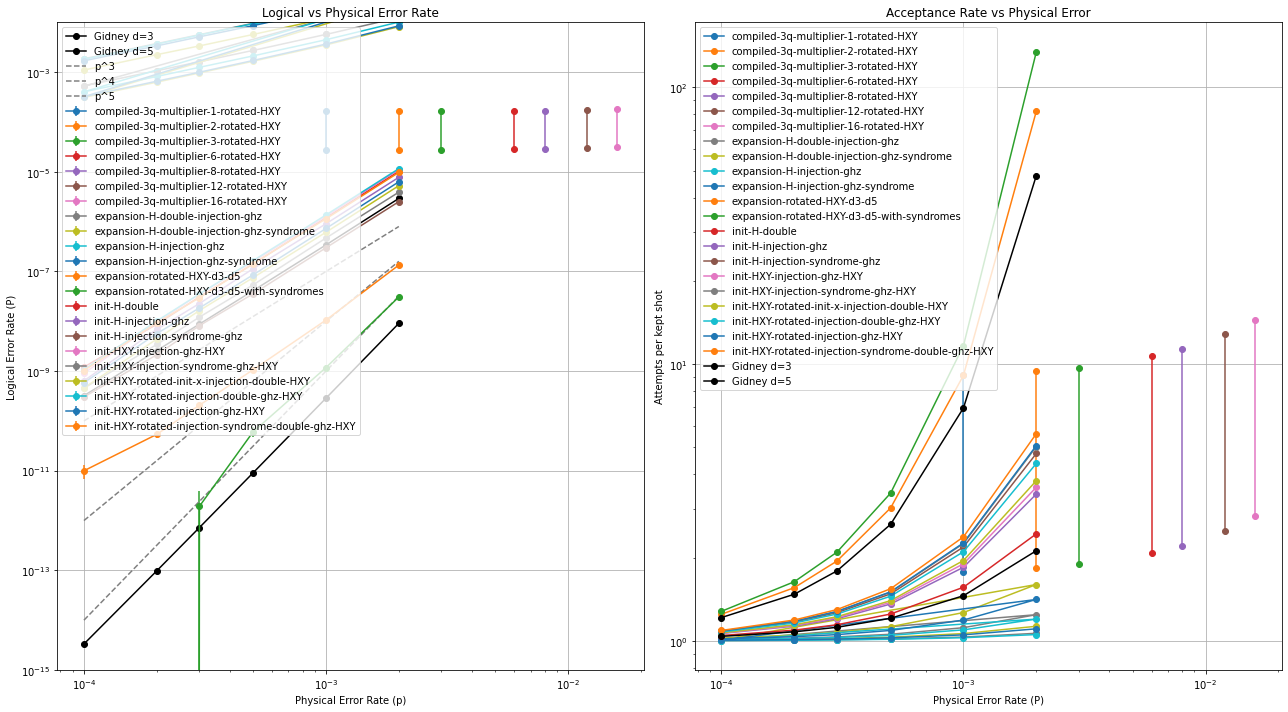

In [176]:
# Filter for num_ghz_measurements = 3
df_ghz3 = df[(df.num_ghz_measurements == 3)&(df.c == 'init-cx')]
df_ghz3_H = df[(df.num_ghz_measurements == 3)&(df.c == 'init-H')]
df_gidney_d3 = df_gidney[(df_gidney.d == 3) & (df_gidney['style'] == 'unitary')]
df_gidney_d5 = df_gidney[(df_gidney.d == 5) & (df_gidney['style'] == 'unitary')]

# circuits_to_skip = ['init-cx', 'init-H', 'init-H-double', 'init-H-double-measure-CZ',
                    # 'init-HXY-rotated-injection-ghz-HXY','init-HXY-injection-syndrome-ghz-HXY']
circuits_to_skip = [
     'end2end-rotated-HXY-d3-d5-with-syndromes',
       'expanded-injection-ghz', 
       'expanded-injection-syndrome-ghz',
       'expanded-rotated-init-x-injection-double-HXY',
       'expanded-rotated-injection-double-HXY',
       'expanded-rotated-syndrome-injection-double-HXY', 'init-H',
    #    'init-H-double', 
    'init-H-double-measure-CZ',#
    #    'init-H-injection-ghz', 'init-H-injection-syndrome-ghz',#
    #    'init-HXY-injection-ghz-HXY',
    #    'init-HXY-injection-syndrome-ghz-HXY',
    #    'init-HXY-rotated-init-x-injection-double-HXY',
    #    'init-HXY-rotated-injection-double-ghz-HXY',
    #    'init-HXY-rotated-injection-ghz-HXY',
    #    'init-HXY-rotated-injection-syndrome-double-ghz-HXY', 
       'init-H',
       'init-cx',
       'init-injection-ghz', 
       'init-injection-syndrome-ghz']
# circuits_to_skip = []
# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10))

# Plot P vs p
# for transversal in ['True', 'False']:
#     data = df_ghz3[df_ghz3.transversal_cx == transversal]
#     ax1.errorbar(data.p, data.P, yerr=data.dP, fmt='o-', 
#                 label=f'Transversal CXX = {transversal}')
for circuit in df.c.unique():
    data = df[df.c == circuit]
    if circuit in circuits_to_skip:
        continue
    ax1.errorbar(data.p, data.P, yerr=data.dP, fmt='o-', label=f'{circuit}')
ax1.plot(df_gidney_d3.p, df_gidney_d3.P, 'o-', label='Gidney d=3', color='black')
ax1.plot(df_gidney_d5.p, df_gidney_d5.P, 'o-', label='Gidney d=5', color='black')

ax1.plot(df_gidney_d5.p, df_gidney_d5.p**3 * 1e2, '--', label='p^3', color='gray')
ax1.plot(df_gidney_d5.p, df_gidney_d5.p**4 * 1e4, '--', label='p^4', color='gray')
ax1.plot(df_gidney_d5.p, df_gidney_d5.p**5 * 1e6, '--', label='p^5', color='gray')
ax1.set_ylabel('Logical Error Rate (P)')
ax1.set_xlabel('Physical Error Rate (p)')
ax1.set_yscale('log')
ax1.set_xscale('log') 
ax1.grid(True)
ax1.legend(loc = 'upper left')
ax1.set_ylim(1e-15,1e-2) 
ax1.set_title('Logical vs Physical Error Rate')

# Create second subplot


# for transversal in ['True', 'False']:
#     factor = 1 if transversal == 'True' else (3/4)
#     data = df_ghz3[df_ghz3.transversal_cx == transversal]
#     ax2.plot(data.p,(factor * data.rate)**(-1), 'o-',
#              label=f'Transversal CXX = {transversal}')

for circuit in df.c.unique():
    if circuit in circuits_to_skip:
        continue
    data = df[df.c == circuit]
    ax2.plot(data.p, 1/data.rate, 'o-', label=f'{circuit}')
ax2.plot(df_gidney_d3.p, 1/df_gidney_d3.rate, 'o-', label='Gidney d=3', color='black')
ax2.plot(df_gidney_d5.p, 1/df_gidney_d5.rate, 'o-', label='Gidney d=5', color='black')
ax2.set_ylabel('Attempts per kept shot') 
ax2.set_xlabel('Physical Error Rate (P)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True)
ax2.legend()
ax2.set_title('Acceptance Rate vs Physical Error')

plt.tight_layout()


0.001
0.001
0.001
0.001
0.001
0.001


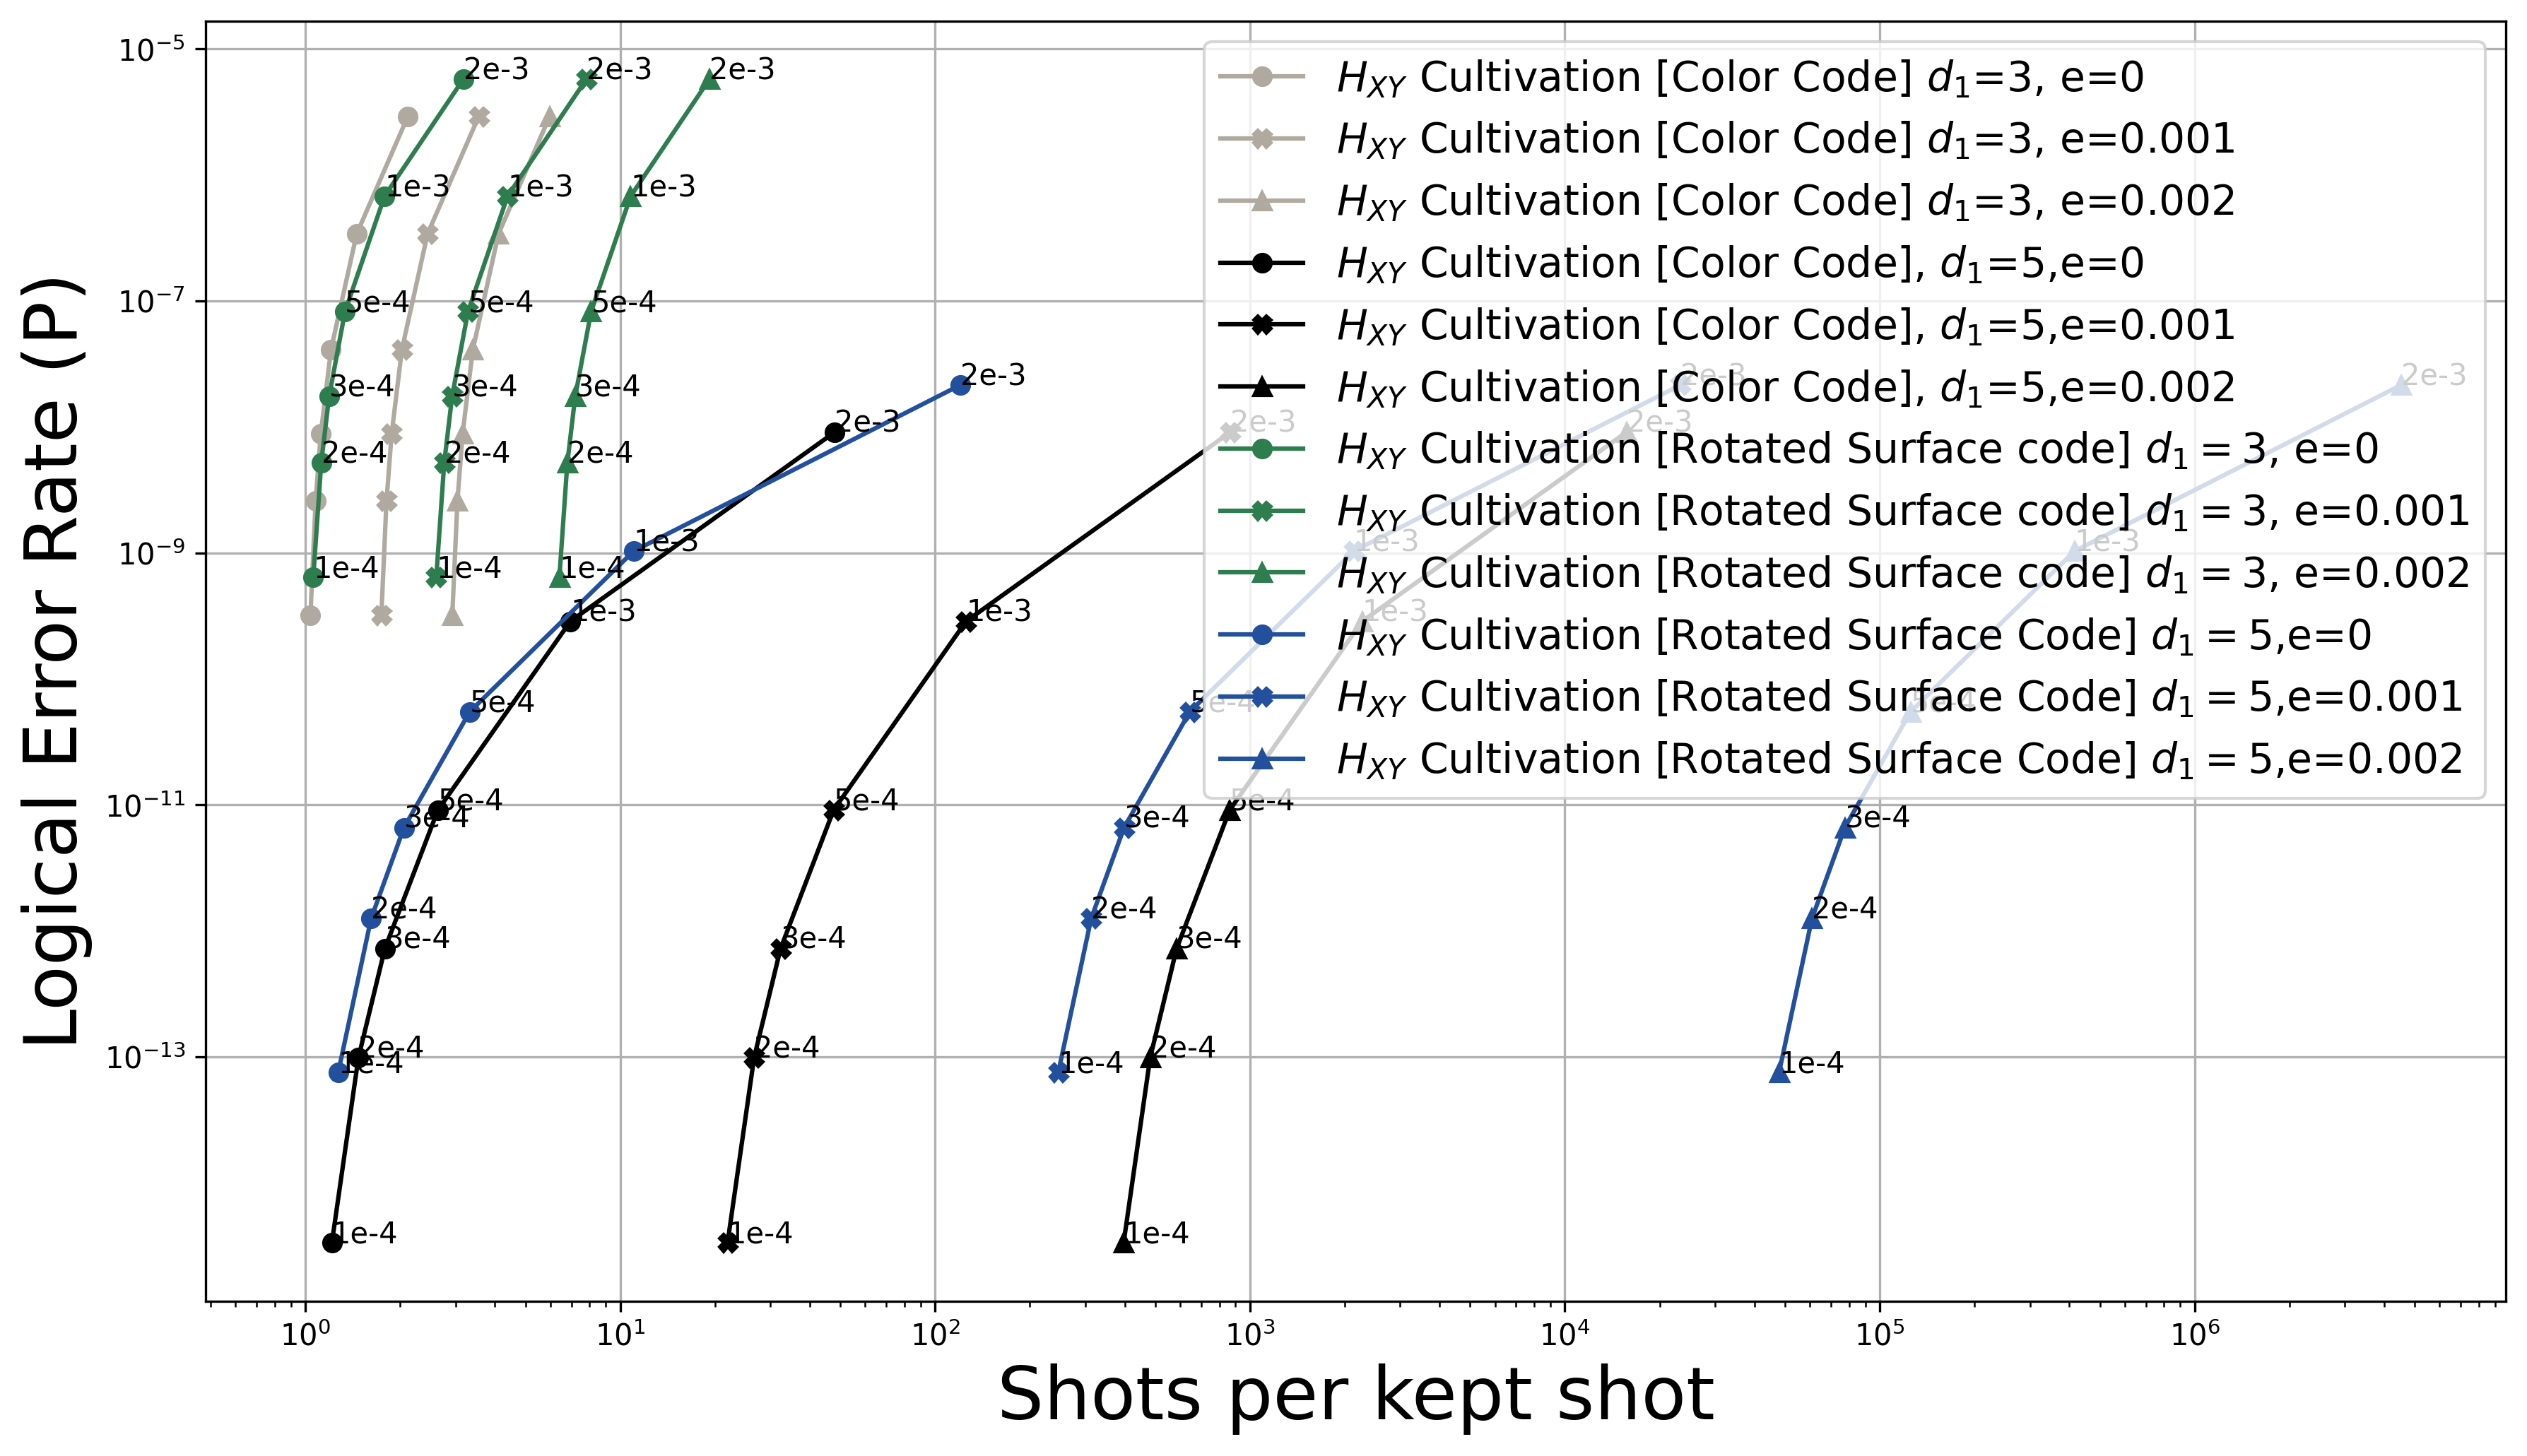

In [213]:

fig, ax = plt.subplots(figsize=(14, 8), dpi = 300)
# Gidney d=3 and d=5
gidney_d3_circuit = stim.Circuit.from_file("../../2024/CX Cultivation/2024-gidney-circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=15,b=Y,r=4,d1=3.stim")
gidney_d5_circuit = stim.Circuit.from_file("../../2024/CX Cultivation/2024-gidney-circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=42,b=Y,r=10,d1=5.stim")
es = [0, 1e-3, 0.002]#, 0.004]
ps = [1e-4, 2e-4, 3e-4, 5e-4, 1e-3, 2e-3]
ps_labels = ["1e-4","2e-4","3e-4", "5e-4","1e-3","2e-3"]
mask3 = (df_gidney_d3.P > 0) & (df_gidney_d3.rate > 0)
mask5 = (df_gidney_d5.P > 0) & (df_gidney_d5.rate > 0)

markers = 'oX^<'
def plot(ax, x, y, fmt, color, label):
    ax.plot(x, y, fmt, label = label, color = color)
    for p_label, rate, fid in zip(ps_labels, x, y):
        ax.text(rate, fid, p_label, fontsize = 10)
    
for e, m in zip(es, markers):
    warm_color = "#b0a99f"  # a warm gray
    d3_gidney_erasure_rate = erasure_probability(gidney_d3_circuit, 0.001, e)
    ax.plot(1/df_gidney_d3.rate[mask3] * (1/d3_gidney_erasure_rate), df_gidney_d3.P[mask3], f'{m}-', label=r'$H_{XY}$ Cultivation [Color Code] $d_1$=3, '+f'e={e}', color=warm_color)
    
for e, m in zip(es, markers):
    warm_color = "black"  # a warm gray
    d5_gidney_erasure_rate = erasure_probability(gidney_d5_circuit, 0.001, e)
    plot(ax, 1/df_gidney_d5.rate[mask5] * (1/d5_gidney_erasure_rate), df_gidney_d5.P[mask5], f'{m}-', label=r'$H_{XY}$ Cultivation [Color Code], $d_1$=5,'+f'e={e}', color=warm_color)

# for e, m in zip(es, markers):
#     ordered_ps, heralded_error_rates, keep_rates, e_rate, report= plot_circuit_type_using_report('init-H-injection-syndrome-ghz', e)
#     ax.plot(keep_rates , heralded_error_rates , f'{m}-', label=f'$H$ Cultivation [Unrotated Surface code] $d_1=3$, e={e}', color = 'red') 

for e, m in zip(es, markers):
    ordered_ps, heralded_error_rates, keep_rates, e_rate, report = plot_circuit_type_using_report('init-HXY-rotated-injection-double-ghz-HXY', e, ps)
    plot(ax, keep_rates, heralded_error_rates, f'{m}-', label=r'$H_{XY}$ Cultivation [Rotated Surface code] $d_1=3$, '+f'e={e}', color='#2e7d4f')

for e, m in zip(es, markers):
    ordered_ps, heralded_error_rates, keep_rates, e_rate, report = plot_circuit_type_using_report('expansion-rotated-HXY-d3-d5-with-syndromes', e, ps)
    plot(ax, keep_rates, heralded_error_rates, f'{m}-', label=r'$H_{XY}$ Cultivation [Rotated Surface Code] $d_1=5$,'+f'e={e}', color = '#23509c')

ax.set_ylabel('Logical Error Rate (P)', fontsize = 25)
ax.set_xlabel('Attemps per kept shot', fontsize = 25)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc = 'upper right', fontsize = 14)

# plt.tight_layout()
plt.savefig("fig/erasure.pdf")

In [197]:
df_expand = df[(df.strong_id != 'bc7bbd93f0b2e938e7763e4efa73482e10e306d7ba3398225db01954f2f24fc7') &(df.decoder == 'PymatchingGapSampler') & ((df.d2.isin([11])) | (df.d3 == 11))]
df_gidney_expanded = cleanup_df("../../2024/CX Cultivation/2024-gidney-stats.csv")
df_gidney_expanded = df_gidney_expanded[(df_gidney_expanded.decoder == 'desaturation') &\
                                         (df_gidney_expanded.p == 1e-3)]



In [214]:
import numpy as np
from itertools import chain

circuit_name_conversion = {'end2end-inplace-distillation' : '$H_{XY}$ Gidney et al. Cultivation [Color Code]',
                           'expanded-rotated-init-x-injection-double-HXY' : r'$H_{XY}$ Cultivation [Rotated Surface Code]',
                           'expanded-injection-ghz' : r'$H$ Cultivation [UnrotatedSurface Code]',
                           'end2end-rotated-HXY-d3-d5-with-syndromes' : r'$H_{XY}$ Cultivation [Rotated Surface Code]',
                           'end2end' : r'CX Cultivation [Rotated Surface Code]',
                           'expansion-H-injection-ghz-syndrome' : '',
                           'compiled-3q-multiplier' : r'$H_{XY}$ Cultivation [Rotated Surface Code]'
                           }

# Improved color scheme: Uniform Noise is a slightly darker, richer version of the primary color;
# Atoms Noise is a lighter, softer version of the primary color.
# All colors are chosen to be visually appealing and harmonious.

label_colors = {
    # $H_{XY}$ Cultivation [Rotated Surface Code], d1=5, d2=11
    r"d1=5, d2=11, p=0.001, $H_{XY}$ Cultivation [Rotated Surface Code], Atoms Noise": "#7fa6ee",   # lighter blue
    r"d1=5, d2=11, p=0.001, $H_{XY}$ Cultivation [Rotated Surface Code], Uniform Noise": "#23509c", # deeper blue

    # $H$ Cultivation [UnrotatedSurface Code], d1=3, d2=11
    r"d1=3, d2=11, p=0.001, $H$ Cultivation [UnrotatedSurface Code], Atoms Noise": "#f28b6c",       # stronger light red-orange
    r"d1=3, d2=11, p=0.001, $H$ Cultivation [UnrotatedSurface Code], Uniform Noise": "#b22222",     # rich firebrick

    # $H_{XY}$ Cultivation [Rotated Surface Code], d1=3, d2=11
    r"d1=3, d2=11, p=0.001, $H_{XY}$ Cultivation [Rotated Surface Code], Atoms Noise": "#7fd89a",   # less light green
    r"d1=3, d2=11, p=0.001, $H_{XY}$ Cultivation [Rotated Surface Code], Uniform Noise": "#2e7d4f", # deeper green

    # $H_{XY}$ Gidney et al. Cultivation [Color Code], d1=3, d2=15 and d1=5, d2=15
    r"d1=3, d2=15, p=0.001, $H_{XY}$ Gidney et al. Cultivation [Color Code], Uniform Noise": "#444444", # dark gray
    r"d1=5, d2=15, p=0.001, $H_{XY}$ Gidney et al. Cultivation [Color Code], Uniform Noise": "#444444", # dark gray

    # CX Cultivation [Rotated Surface Code], d1=3, d2=11
    r"d1=3, d2=11, p=0.001, CX Cultivation [Rotated Surface Code], Uniform Noise": "#bfa43a",       # rich gold
    r"d1=3, d2=11, p=0.001, CX Cultivation [Rotated Surface Code], Atoms Noise": "#f3e6a2",         # lighter gold

    # CX Cultivation [Rotated Surface Code], d1=5, d2=11
    r"d1=5, d2=11, p=0.001, CX Cultivation [Rotated Surface Code], Uniform Noise": "#7c3fa0",       # deep violet
    r"d1=5, d2=11, p=0.001, CX Cultivation [Rotated Surface Code], Atoms Noise": "#c7a6e5",         # lighter violet
}

label_colors = {k.replace('p=0.001, ', ''): v for k, v in label_colors.items()}

noise_labels = {
    'uniform': 'Uniform Noise',
    'uniform_atoms': 'Atoms Noise',
}

noise_colors = {
    'uniform': '#2e7d4f',
    'uniform_atoms': '#7fd89a',
}

def plot_success_vs_acceptance(
    dfs,
    circuit_name_conversion,
    circuit_name=None,
    ax=None,
    legend_loc='upper right',
    title='Success Probability vs Acceptance Probability',
    fontsize = 12,
    legend_fontsize = 12,
    xlim = (1e0, 3e3),
    ylim = (1e-11, 1e6),
    random_colors = False,
    xscale = 'log',
    yscale = 'log',
    scale_by_depth = False,
    scale_by_volume = False,
    label_p = False,
    color_by_p = False
):
    """
    Plot logical error rate vs acceptance probability for one or more dataframes.

    Args:
        dfs: A dataframe or list/tuple of dataframes to iterate over.
        circuit_name_conversion: dict mapping circuit names to pretty labels.
        circuit_name: If not None, only plot rows with this circuit name.
        ax: matplotlib axis to plot on (optional).
        legend_loc: legend location.
        title: plot title.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import chain

    if not isinstance(dfs, (list, tuple)):
        dfs = [dfs]

    if ax is None:
        fig, ax = plt.subplots(figsize=(14,8), dpi = 300)

    for df in dfs:
        for idx, row in df.iterrows():
            if circuit_name is not None and row.c != circuit_name:
                continue
            if row.c not in circuit_name_conversion and circuit_name_conversion:
                continue
            counts = eval(row.custom_counts)
            # Get max index to determine range
            max_idx = max([int(k[1:]) for k in counts.keys() if k[0] in ['C','E']]) 
            thresholds = range(0, max_idx+1, 1)
            successes = []
            errors = []
            acceptance_probs = []
            total_shots = sum(v for k,v in counts.items())
            found_print = False  # Track if we've printed for this row
            found_print_5 = False  # Track if we've printed for this row
            glob_path = f"./circuits/*/c={row.c}*d?={int(row.d1)}*d?={int(row.d2)}*p={row.p}*noise={row.noise}.stim"
            glob_path_second= f"./circuits/*/c={row.c}*d?={int(row.d2)}*d?={int(row.d1)}*p={row.p}*noise={row.noise}.stim"
            gidney_path = f"./circuits/*/c={row.c}*p={row.p}*d?={int(row.d1)}*d?={int(row.d2)}*.stim"
            all_files_for_circuit = glob.glob(glob_path) + glob.glob(glob_path_second) + glob.glob(gidney_path)
            if len(all_files_for_circuit) == 1:
                stim_circuit = stim.Circuit.from_file(all_files_for_circuit[0])
            else:
                if len(all_files_for_circuit) == 0:
                    print(f"No Stim Circuits Found for {row.c}")
                    stim_circuit = None
                else:
                    print(f"Found {len(all_files_for_circuit)} Stim Circuits for {row.c}")
                    stim_circuit = stim.Circuit.from_file(all_files_for_circuit[0])

            for t in thresholds:
                # Sum all counts above threshold
                success = sum(v for k,v in counts.items() if k[0]=='C' and int(k[1:])>=t)
                error = sum(v for k,v in counts.items() if k[0]=='E' and int(k[1:])>=t)
                total = success + error
                acceptance_prob = total/total_shots
                acceptance_probs.append(acceptance_prob*row.rate)
                if total > 0:
                    p_success = success/(total)
                    if p_success < 1:
                    # Calculate standard error
                        std_err = np.sqrt(p_success*(1-p_success)/total)
                        successes.append(p_success)
                        errors.append(std_err)
                    else:
                        successes.append(np.nan)
                        errors.append(np.nan)
                else:
                    successes.append(np.nan)
                    errors.append(np.nan)
                # Print the rate at the first time the infidelity is below 1E-7
                if not found_print and total > 0 and (1 - p_success) < 1e-7:
                    print(f"First infidelity < 1e-7 for circuit '{row.c}' (label: {circuit_name_conversion.get(row.c, row.c)}), noise '{row.noise}', at rate: {acceptance_prob*row.rate}")
                    found_print = True
                if not found_print_5 and total > 0 and (1 - p_success) < 1e-5:
                    print(f"First infidelity < 1e-5 for circuit '{row.c}' (label: {circuit_name_conversion.get(row.c, row.c)}), noise '{row.noise}', at rate: {acceptance_prob*row.rate}")
                    found_print_5 = True
            # Determine d1, d2
            if hasattr(row, 'd3') and not pd.isnull(row.d3) and row.d3 > 0:
                d1 = int(row.d2)
                d2 = int(row.d3)
            else:
                d1 = int(row.d1)
                d2 = int(row.d2)
            # Choose marker style
            circ_name = circuit_name_conversion.get(row.c, row.c)
            # label = f'd1={str(d1)}, d2={d2}, p={row.p}, {circ_name}{"," if circ_name != "" else ""} {noise_labels.get(row.noise, row.noise)}'
            label = f'd1={str(d1)}, d2={d2}'
            if label_p:
                label += r', $p_{3Q}$'+f'={row.p}'
            label += f', {circ_name}{"," if circ_name != "" else ""} {noise_labels.get(row.noise, row.noise)}'
            # Assign a color based on the label using a hash function and matplotlib colormap
            import matplotlib.cm as cm
            import matplotlib.colors as mcolors

            rounds = 4 if row.d1 == 3 else 6

            if scale_by_depth:
                tick_scaler = CircuitAnalyzer(stim_circuit).standardized_depth(rounds = rounds)
            elif scale_by_volume:
                tick_scaler = CircuitAnalyzer(stim_circuit).standardized_volume()
            else:
                tick_scaler = 1


            # Use a colormap with a large number of colors (e.g., 'tab20' or 'nipy_spectral')

            if 'end2end' in row.c and 'rotated' not in row.c:
                fmt = '*-'
            elif row.noise == 'uniform_atoms':
                fmt = '^-'
            elif row.noise == 'uniform':
                fmt = 'o-'
            # Pass the color explicitly to errorbar
            if random_colors:
                # If random_colors is True, pick a color from a specific colormap (e.g., 'nipy_spectral')
                # Use a hash of the label to pick a color in [0,1]
                fmt_kwargs = {'fmt': fmt}
            elif color_by_p:
                # Set alpha based on p, with p varying between 1e-3 and 1e-2
                # We'll map p=1e-3 to alpha=0.4 and p=1e-2 to alpha=1.0 linearly
                fmt_kwargs = {'fmt': fmt, 'color': noise_colors.get(row.noise, 'black'), 'alpha': row.p/2e-2}
            else:
                fmt_kwargs = {'fmt': fmt, 'color': label_colors.get(label, 'black')}
            ax.errorbar(
                1/np.array(acceptance_probs) * tick_scaler,
                1-np.array(successes),
                yerr=errors,
                **fmt_kwargs,
                label=label
            )
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlabel('Attemps per kept shot', fontsize=fontsize)
    ax.set_ylabel('Logical Error Rate', fontsize=fontsize)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.grid(True)
    ax.legend(loc=legend_loc, fontsize=legend_fontsize, ncol=1)
    if ax is None:
        plt.show()

# Example usage:

In [215]:
df_expand = df[(df.strong_id != 'bc7bbd93f0b2e938e7763e4efa73482e10e306d7ba3398225db01954f2f24fc7') &(df.decoder == 'PymatchingGapSampler') & ((df.d2.isin([11])) | (df.d3 == 11))]
df_expand_no_atoms = df_expand[(df_expand.noise == 'uniform') & (df_expand.p == 1e-3) & (df_expand.d1 == 3)]
df_expand_atoms = df_expand[(df_expand.noise == 'uniform_atoms') & (df_expand.p == 1e-3) & (df_expand.d1 == 3)]
df_gidney_expanded = cleanup_df("../../2024/CX Cultivation/2024-gidney-stats.csv")
df_gidney_expanded = df_gidney_expanded[(df_gidney_expanded.decoder == 'desaturation') &\
                                         (df_gidney_expanded.p == 1e-3)]

df_expand_d2 = df_expand[(df_expand.d1 == 2) & (df_expand.d2 == 11) & (df_expand.p == 1e-3) & (df_expand.noise == 'uniform')]
df_expand_d2_atoms = df_expand[(df_expand.d1 == 2) & (df_expand.d2 == 11) & (df_expand.p == 1e-3) & (df_expand.noise == 'uniform_atoms')]
df_all_d2 = df_expand[(df_expand.d1 == 2) & (df_expand.d2 == 11)]

df_cx = cleanup_df("../../2024/CX Cultivation/combined_stats.csv")
df_cx_no_atoms = df_cx[(df_cx.c == 'end2end') & (df_cx.decoder == 'GapSampler') & (df_cx.d2 == 11) & (df_cx.p == 1e-3) & (df_cx.noise == 'uniform')]
df_cx_atoms = df_cx[(df_cx.c == 'end2end') & (df_cx.decoder == 'GapSampler') & (df_cx.d2 == 11) & (df_cx.p == 1e-3) & (df_cx.noise == 'uniform_atoms')]
df_compiled = df[df.c.str.startswith('compiled-3q-multiplier')]
df_compiled.loc[:, 'c'] = 'compiled-3q-multiplier'

First infidelity < 1e-5 for circuit 'end2end-inplace-distillation' (label: $H_{XY}$ Gidney et al. Cultivation [Color Code]), noise 'uniform', at rate: 0.397554672
First infidelity < 1e-5 for circuit 'end2end-inplace-distillation' (label: $H_{XY}$ Gidney et al. Cultivation [Color Code]), noise 'uniform', at rate: 0.050643001085
First infidelity < 1e-7 for circuit 'end2end-inplace-distillation' (label: $H_{XY}$ Gidney et al. Cultivation [Color Code]), noise 'uniform', at rate: 0.033819325885
First infidelity < 1e-5 for circuit 'end2end-rotated-HXY-d3-d5-with-syndromes' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform', at rate: 0.09936110230386395
First infidelity < 1e-7 for circuit 'end2end-rotated-HXY-d3-d5-with-syndromes' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform', at rate: 0.09072843060700232
First infidelity < 1e-5 for circuit 'expanded-injection-ghz' (label: $H$ Cultivation [UnrotatedSurface Code]), noise 'uniform', at rate: 0.53919577

Text(10, 1e-10, 'This Work $d_1=5$')

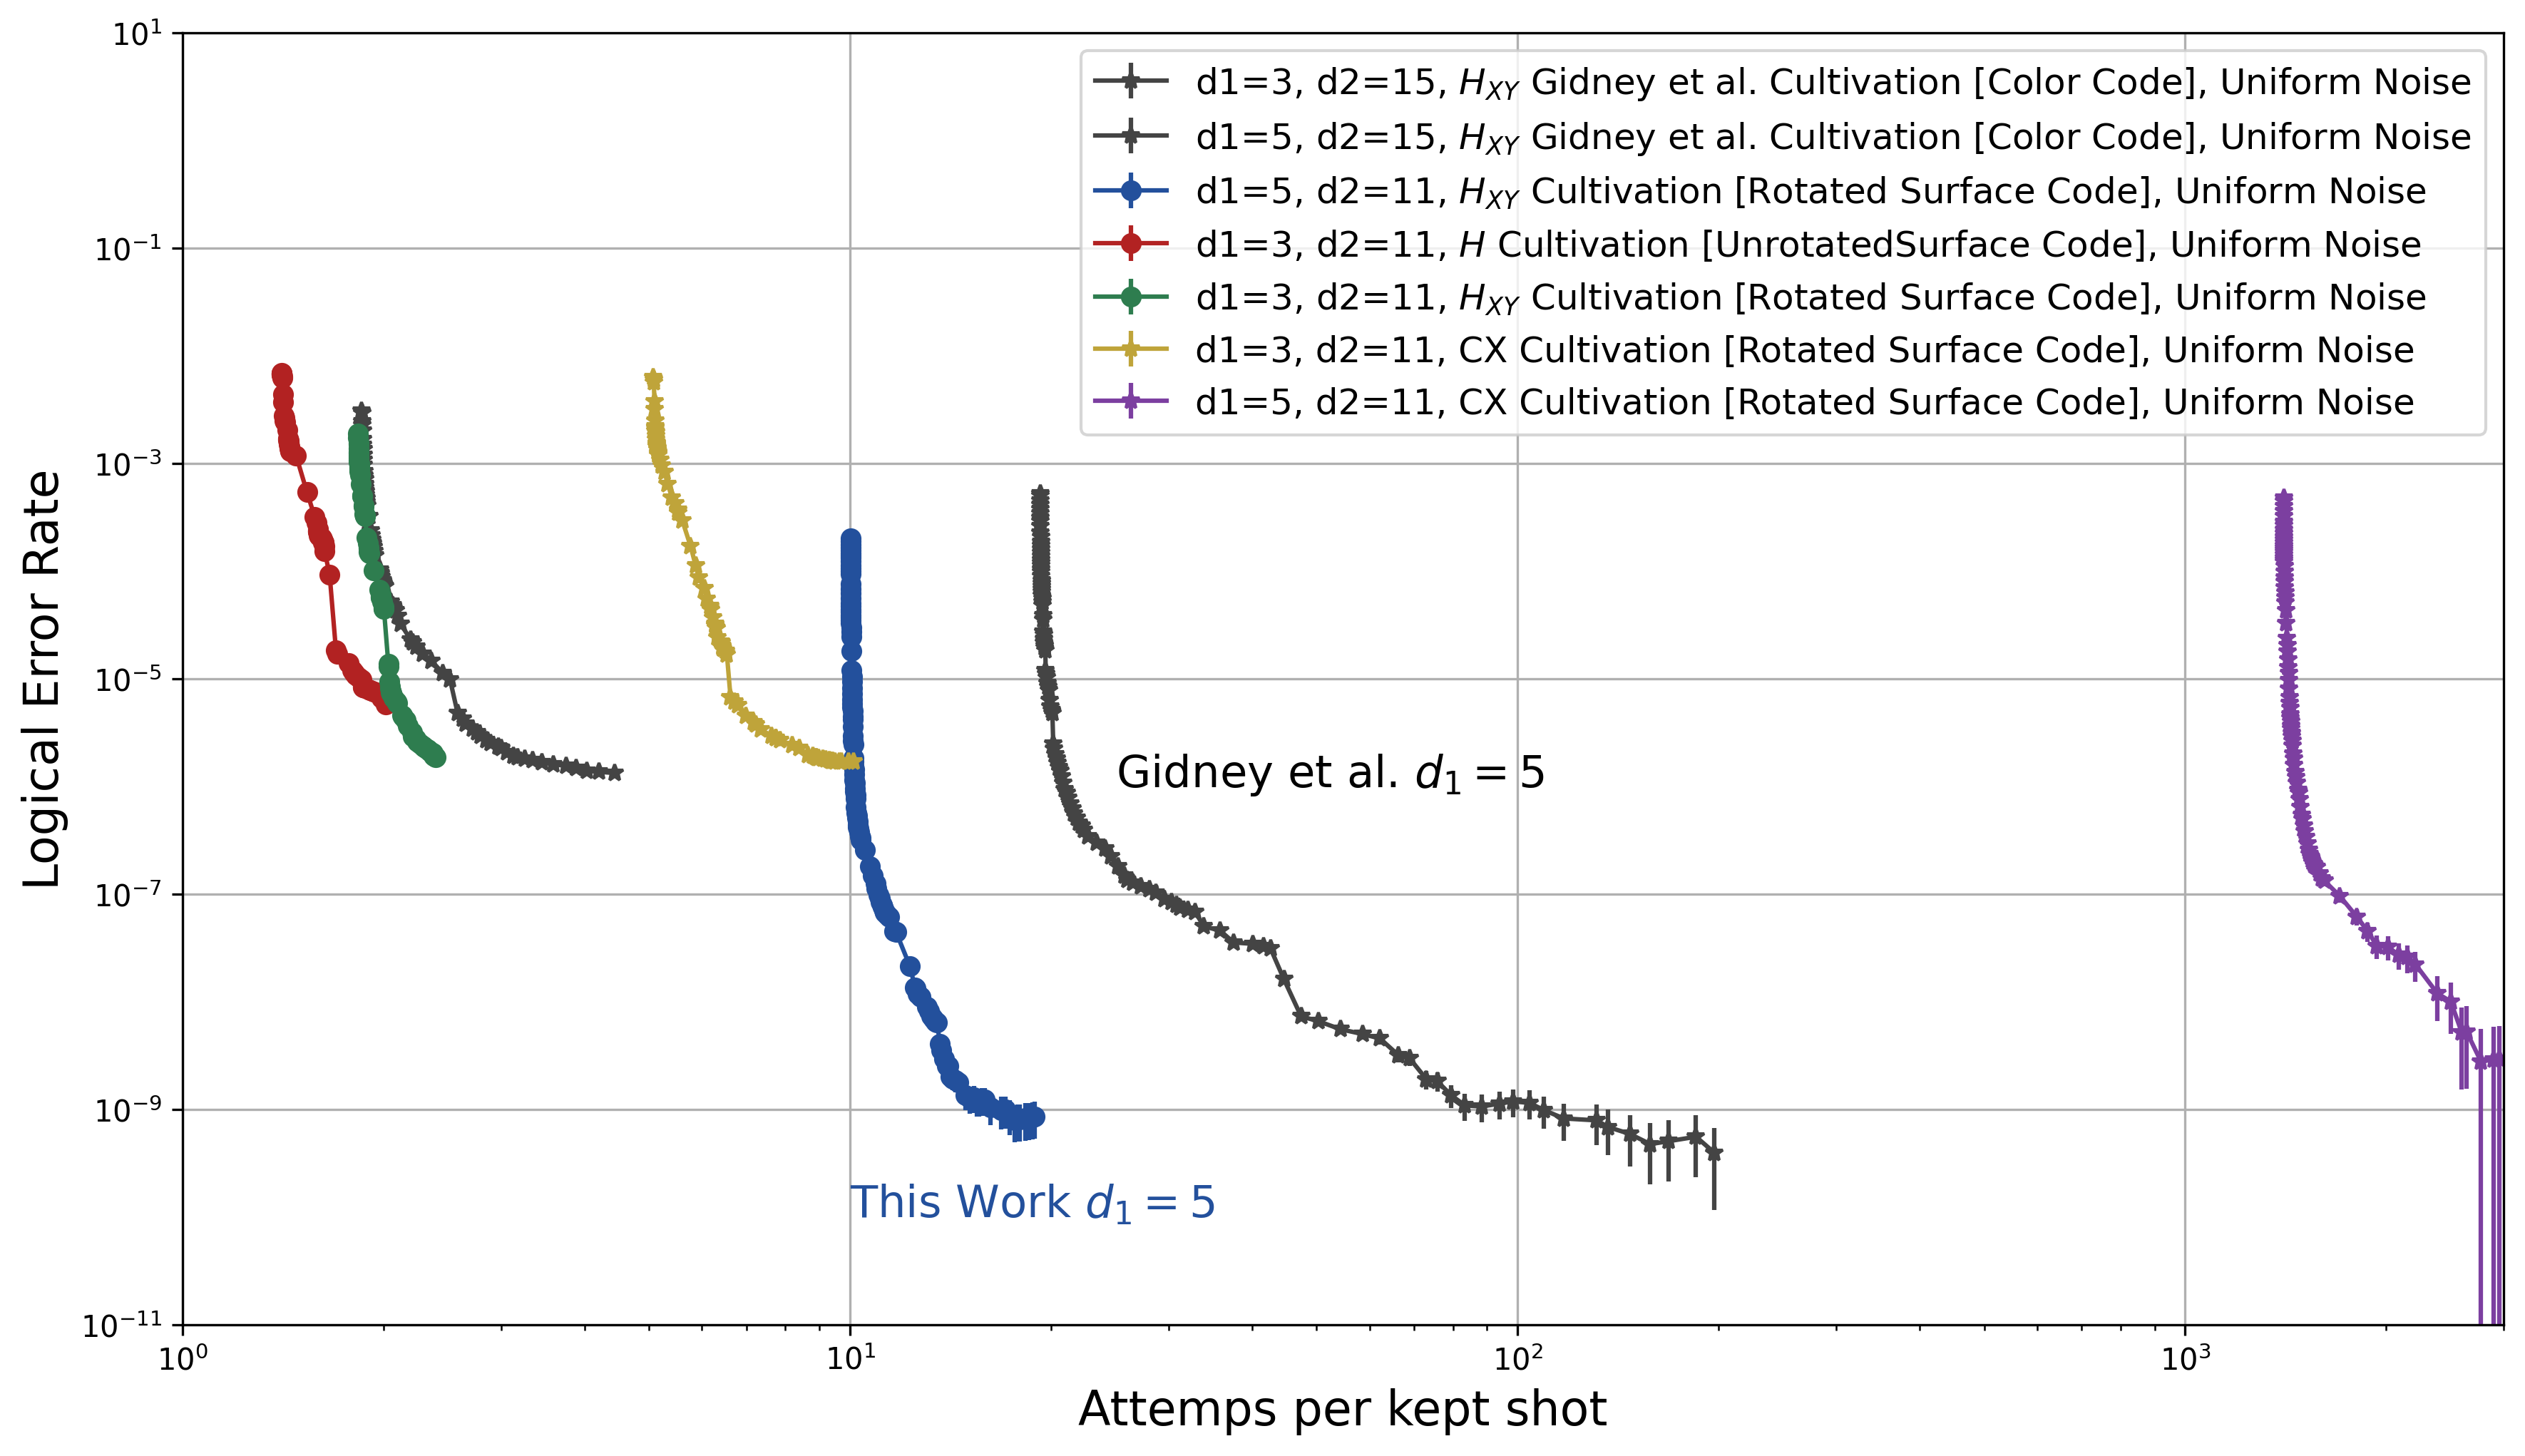

In [216]:
plot_success_vs_acceptance([df_gidney_expanded, df_expand_no_atoms, df_cx_no_atoms], 
                           circuit_name_conversion,
                           title = 'Success vs Acceptance',
                           fontsize=16, legend_fontsize=12,ylim=(1e-11, 1e1))

plt.text(25, 1e-6, "Gidney et al. $d_1=5$", fontsize = 15)
plt.text(10, 1e-10, "This Work $d_1=5$", color = "#23509c", fontsize = 15)
# plt.savefig("fig/cultivation_and_expansion.png", dpi=300)

First infidelity < 1e-5 for circuit 'end2end-inplace-distillation' (label: $H_{XY}$ Gidney et al. Cultivation [Color Code]), noise 'uniform', at rate: 0.397554672
First infidelity < 1e-5 for circuit 'end2end-inplace-distillation' (label: $H_{XY}$ Gidney et al. Cultivation [Color Code]), noise 'uniform', at rate: 0.050643001085
First infidelity < 1e-7 for circuit 'end2end-inplace-distillation' (label: $H_{XY}$ Gidney et al. Cultivation [Color Code]), noise 'uniform', at rate: 0.033819325885
First infidelity < 1e-5 for circuit 'end2end-rotated-HXY-d3-d5-with-syndromes' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform', at rate: 0.09936110230386395
First infidelity < 1e-7 for circuit 'end2end-rotated-HXY-d3-d5-with-syndromes' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform', at rate: 0.09072843060700232
First infidelity < 1e-5 for circuit 'expanded-injection-ghz' (label: $H$ Cultivation [UnrotatedSurface Code]), noise 'uniform', at rate: 0.53919577

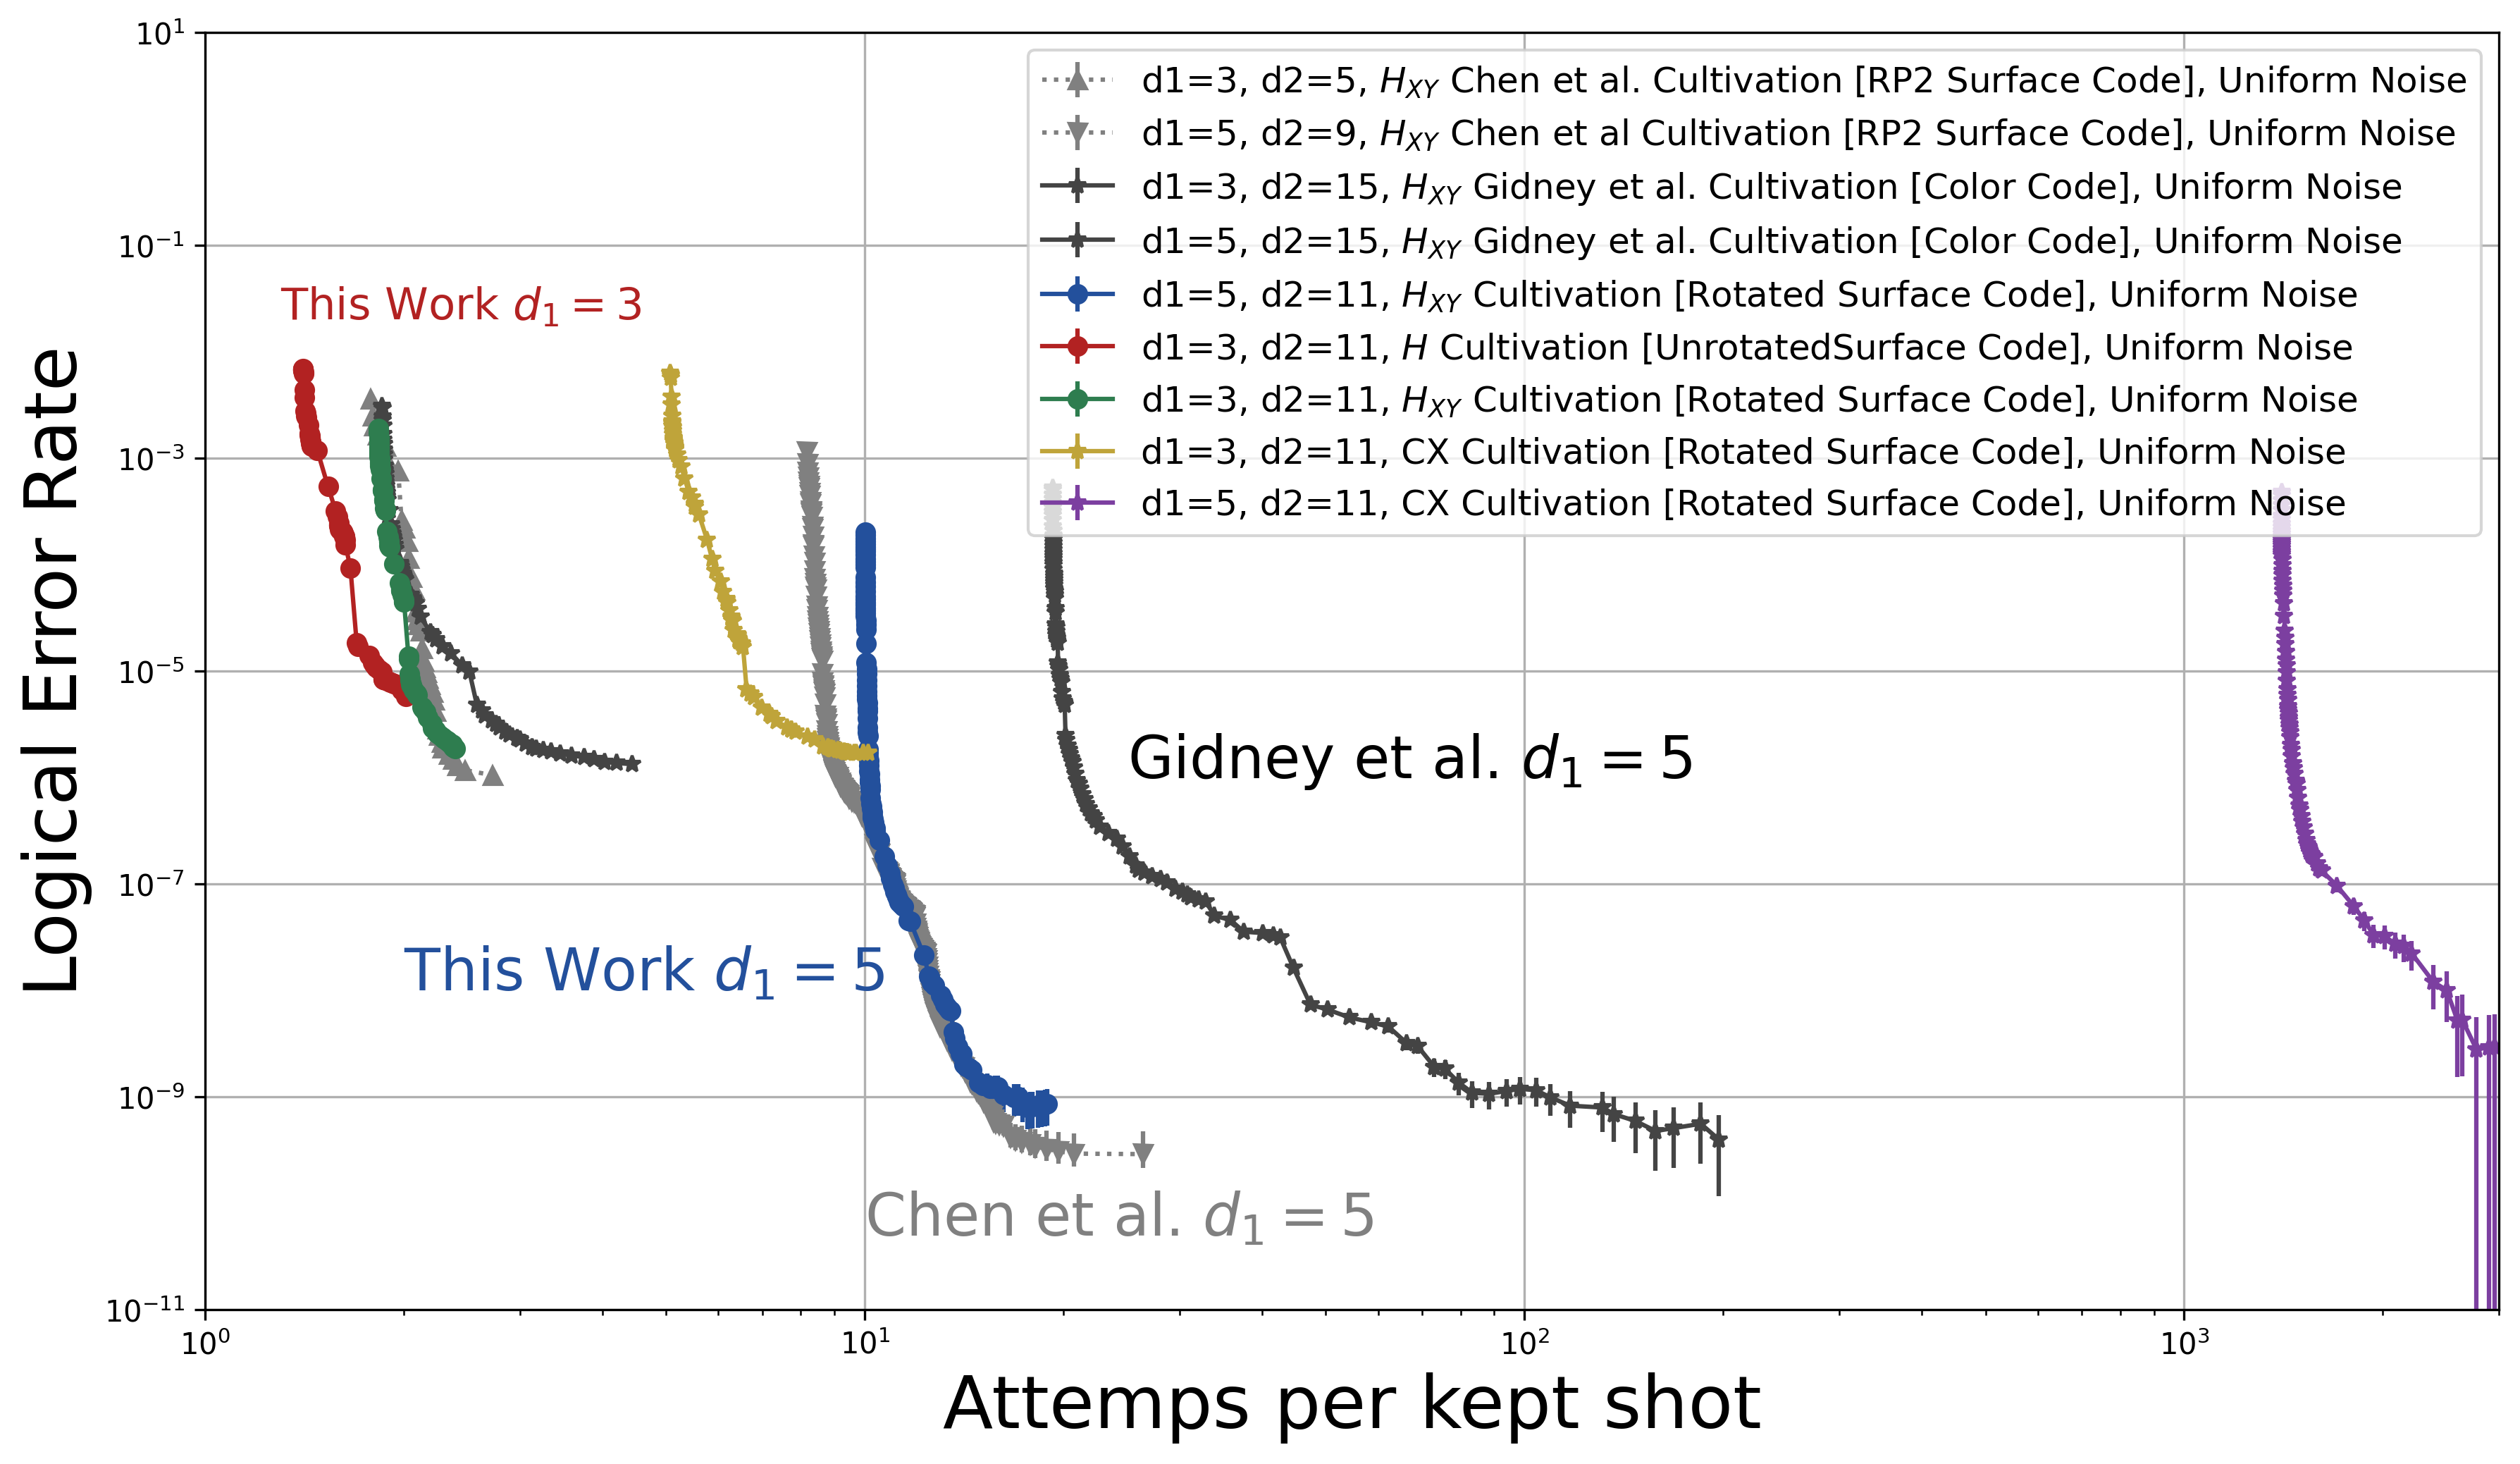

In [217]:
fig, ax= plt.subplots(figsize=(14, 8), dpi = 300)

circuit_analyzer_rp2_d3 = CircuitAnalyzer("/Users/yotam/Documents/GitHub/Titus/2025/HCultivationSurfaceCode/rpdata/circuit_garage/rp_3_T_cult.stim")
circuit_analyzer_rp2_d3 = CircuitAnalyzer("/Users/yotam/Documents/GitHub/Titus/2025/HCultivationSurfaceCode/rpdata/circuit_garage/rp_3_sc_7_end2end_4_full_rds.stim")
circuit_analyzer_rp2_d3.final_rounds = 4

# Calculate asymmetric error bars for d3: high is (high - best), low is (best - low)
yerr_d3 = np.array([
    np.array(selected_d3_err_rate_best) - np.array(selected_d3_err_rate_low),
    np.array(selected_d3_err_rate_high) - np.array(selected_d3_err_rate_best)
]) / 3.29 #1/1000 region

plt.errorbar(
    np.array(selected_d3_retry_rate),  # * circuit_analyzer_rp2_d3.standardized_depth(rounds = 4),
    np.array(selected_d3_err_rate_best),
    marker='^',
    yerr=yerr_d3,
    linestyle='dotted',
    color='gray',
    label='d1=3, d2=5, $H_{XY}$ Chen et al. Cultivation [RP2 Surface Code], Uniform Noise'
)
circuit_analyzer_rp2_d5 = CircuitAnalyzer("/Users/yotam/Documents/GitHub/Titus/2025/HCultivationSurfaceCode/rpdata/circuit_garage/rp_3_rp_5_T_cult.stim")
circuit_analyzer_rp2_d5 = CircuitAnalyzer("/Users/yotam/Documents/GitHub/Titus/2025/HCultivationSurfaceCode/rpdata/circuit_garage/rp_3_rp_5_sc_11_end2end_6_full_rds.stim")
circuit_analyzer_rp2_d5.final_rounds = 6

# Calculate asymmetric error bars: high is (high - best), low is (best - low)
yerr = np.array([
    np.array(selected_d5_err_rate_best) - np.array(selected_d5_err_rate_low),
    np.array(selected_d5_err_rate_high) - np.array(selected_d5_err_rate_best)
]) / 3.29 #1/1000 region
plt.errorbar(
    np.array(selected_d5_retry_rate),  # * circuit_analyzer_rp2_d5.standardized_depth(rounds = 6),
    np.array(selected_d5_err_rate_best),
    marker='v',
    yerr=yerr,
    linestyle='dotted',
    color='gray',
    label='d1=5, d2=9, $H_{XY}$ Chen et al Cultivation [RP2 Surface Code], Uniform Noise'
)

plot_success_vs_acceptance([df_gidney_expanded, df_expand_no_atoms, df_cx_no_atoms], 
                           circuit_name_conversion,
                           title = 'Success vs Acceptance',
                           fontsize=25, legend_fontsize=12,ylim=(1e-11, 1e1),
                           ax = ax,
                        #    xlim=(1e1, 1e6),
                        #    scale_by_depth= True)
)
# plt.legend()
# plt.legend(fontsize = 12)
plt.text(25, 1e-6, "Gidney et al. $d_1=5$", fontsize = 20)
plt.text(10, 0.5e-10, "Chen et al. $d_1=5$", color = "gray", fontsize = 20)
plt.text(2, 1e-8, "This Work $d_1=5$", color = "#23509c", fontsize = 20)

plt.text(1.3, 2e-2, "This Work $d_1=3$", color = "#b22222", fontsize = 15)


plt.savefig("fig/cultivation_and_expansion.pdf", dpi=300)

First infidelity < 1e-5 for circuit 'end2end-rotated-HXY-d3-d5-with-syndromes' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform_atoms', at rate: 0.527569835855124
First infidelity < 1e-7 for circuit 'end2end-rotated-HXY-d3-d5-with-syndromes' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform_atoms', at rate: 0.5254371265788594
First infidelity < 1e-5 for circuit 'expanded-injection-ghz' (label: $H$ Cultivation [UnrotatedSurface Code]), noise 'uniform_atoms', at rate: 0.865741019279925
First infidelity < 1e-7 for circuit 'expanded-injection-ghz' (label: $H$ Cultivation [UnrotatedSurface Code]), noise 'uniform_atoms', at rate: 0.7592342044642547
First infidelity < 1e-5 for circuit 'expanded-rotated-init-x-injection-double-HXY' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform_atoms', at rate: 0.8276971475550974
First infidelity < 1e-7 for circuit 'expanded-rotated-init-x-injection-double-HXY' (label: $H_{XY}$ Cultivation [Rotated S

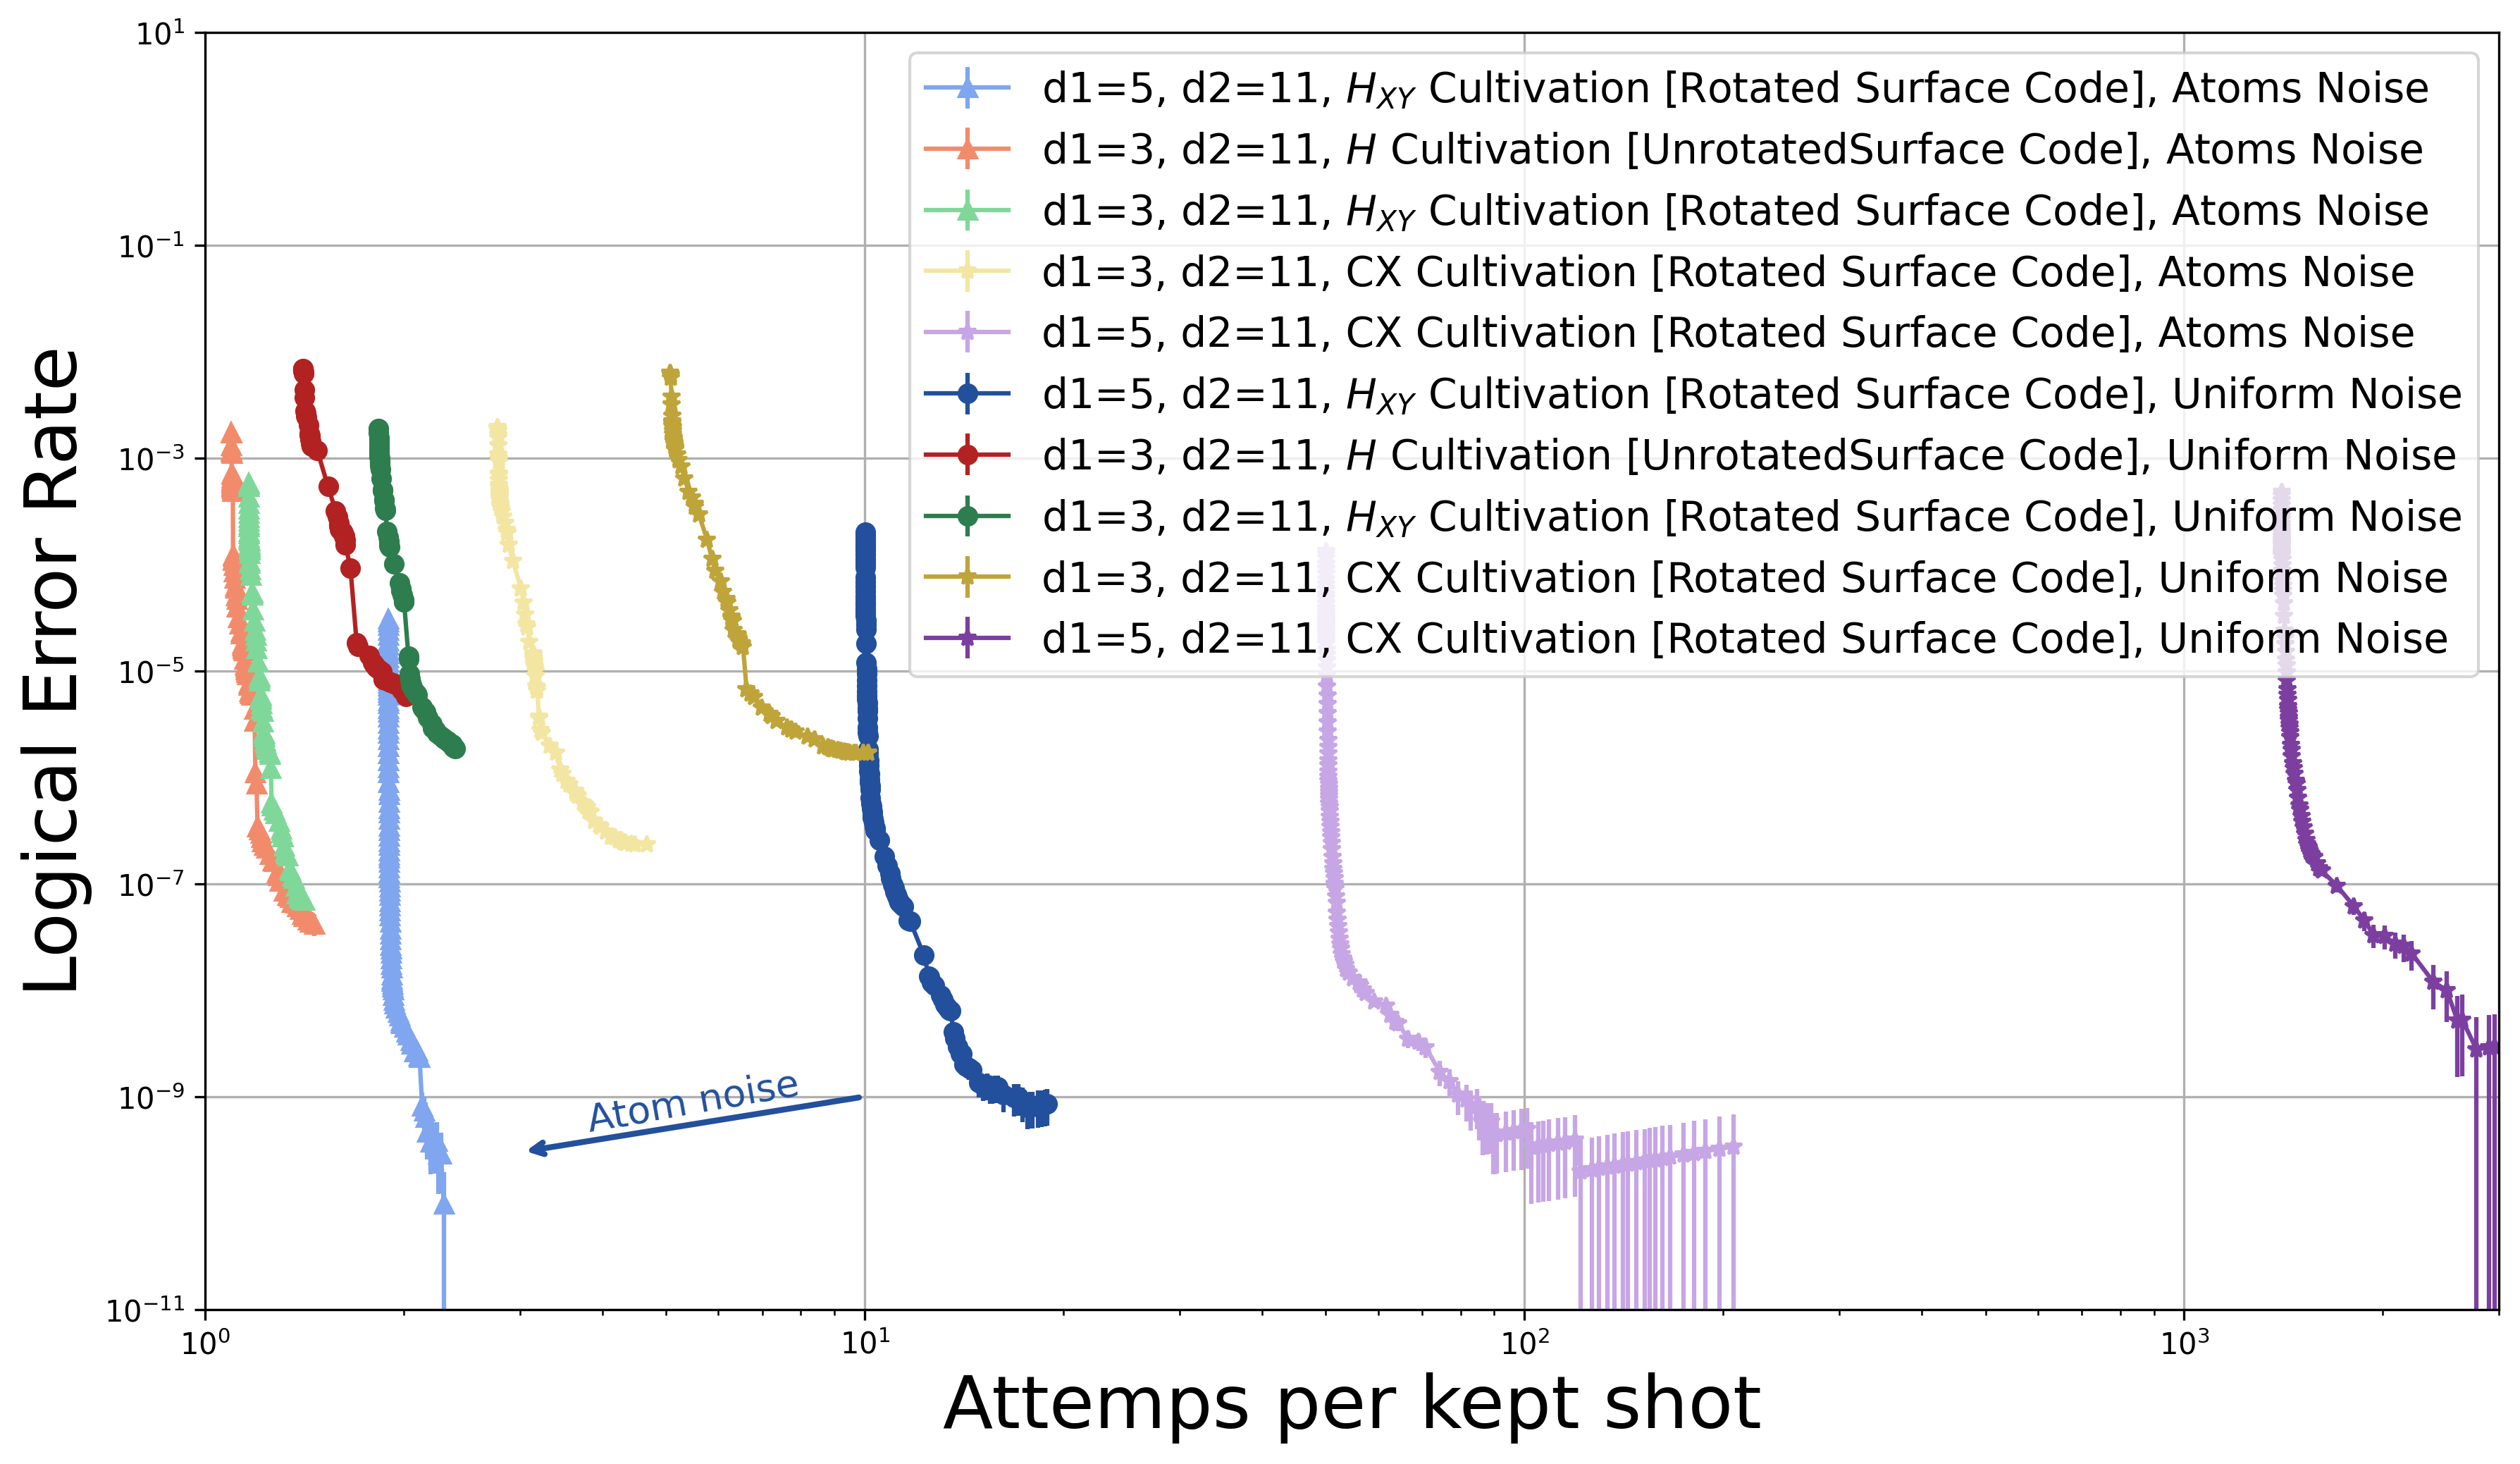

In [218]:
plot_success_vs_acceptance([df_expand_atoms, df_cx_atoms,df_expand_no_atoms, df_cx_no_atoms], 
                           circuit_name_conversion,
                           title = 'Success vs Acceptance',
                           fontsize=25, legend_fontsize=14, ylim = (1e-11, 1e1))
plt.annotate(
    '', 
    xy=(3, 3e-10), 
    xytext=(10, 1e-9), 
    arrowprops=dict(arrowstyle='->', color='#23509c', lw=2)
)
plt.text(5.5, 4e-10, "Atom noise", color='#23509c', fontsize=13, ha='center', va='bottom', rotation=10)


plt.savefig("fig/cultivation_and_expansion_atoms.pdf", dpi=300)

In [219]:
plot_success_vs_acceptance(df_all_d2, circuit_name_conversion, title = 'Success vs Acceptance', fontsize=16, legend_fontsize=12, random_colors=True,
                           xlim = (1,1.5),  xscale = 'linear', ylim = (1e-8, 1e1), fontsize = 25)
# plt.legend(loc='upper left')
plt.savefig("fig/success_vs_acceptance_d2.png", dpi=300)

SyntaxError: keyword argument repeated: fontsize (3656561957.py, line 2)

First infidelity < 1e-5 for circuit 'compiled-3q-multiplier' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform', at rate: 0.10902736692782022
First infidelity < 1e-7 for circuit 'compiled-3q-multiplier' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform', at rate: 0.09984898577864061
First infidelity < 1e-5 for circuit 'compiled-3q-multiplier' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform', at rate: 0.10570144257830885
First infidelity < 1e-7 for circuit 'compiled-3q-multiplier' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform', at rate: 0.09815279774916424
First infidelity < 1e-5 for circuit 'compiled-3q-multiplier' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform', at rate: 0.10251728800053873
First infidelity < 1e-7 for circuit 'compiled-3q-multiplier' (label: $H_{XY}$ Cultivation [Rotated Surface Code]), noise 'uniform', at rate: 0.09559282801678765
First infidelity < 1e-5 for circui

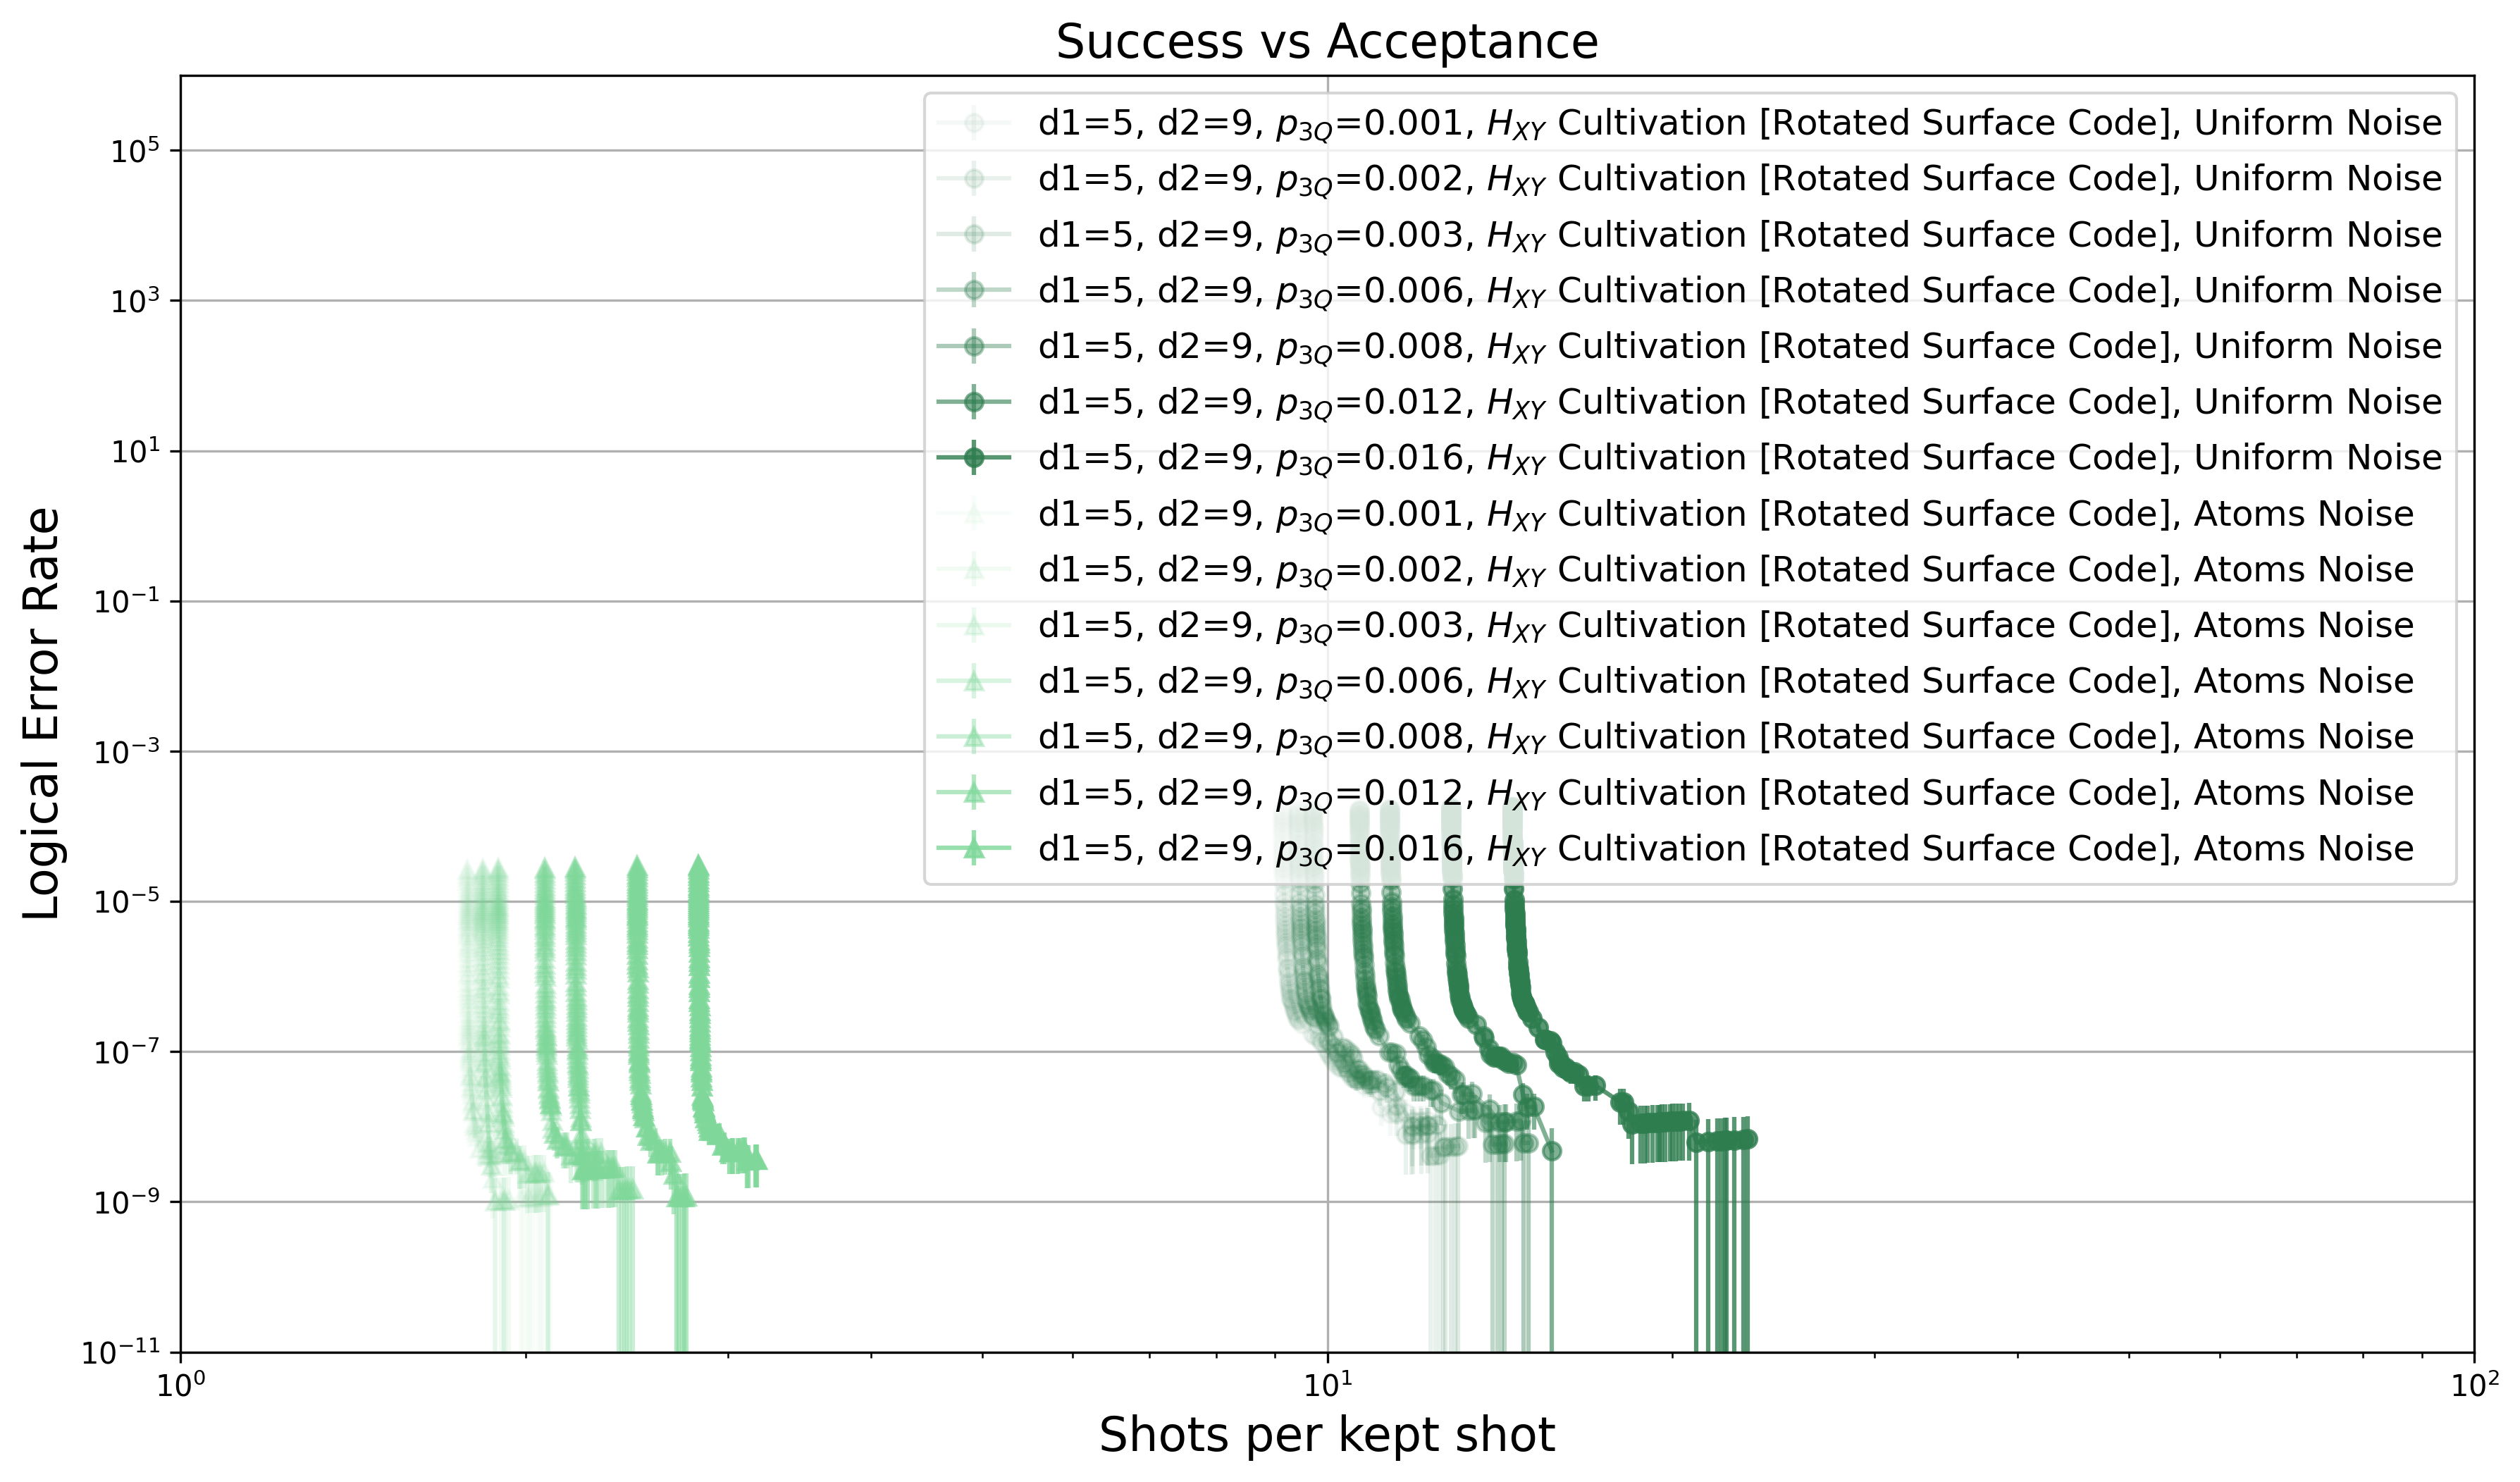

In [ ]:
plot_success_vs_acceptance(df_compiled.sort_values(by = 'noise'), {'compiled-3q-multiplier': circuit_name_conversion['compiled-3q-multiplier']}, title = 'Success vs Acceptance', 
                           fontsize=25, legend_fontsize=12, 
                           xlim = (1, 100),
                           label_p = True,
                           color_by_p = True)
                        
plt.savefig("fig/compiled_3q_multiplier.pdf", dpi=300)

import sys
sys.path.append('./cultiv_code/src')
from cultiv import ErrorEnumerationReport
import glob
import stim
from tqdm.notebook import tqdm

0.001
    cache miss fa96c67f9a3d05858a5d1eefac9ae6abdb294b54
0.001


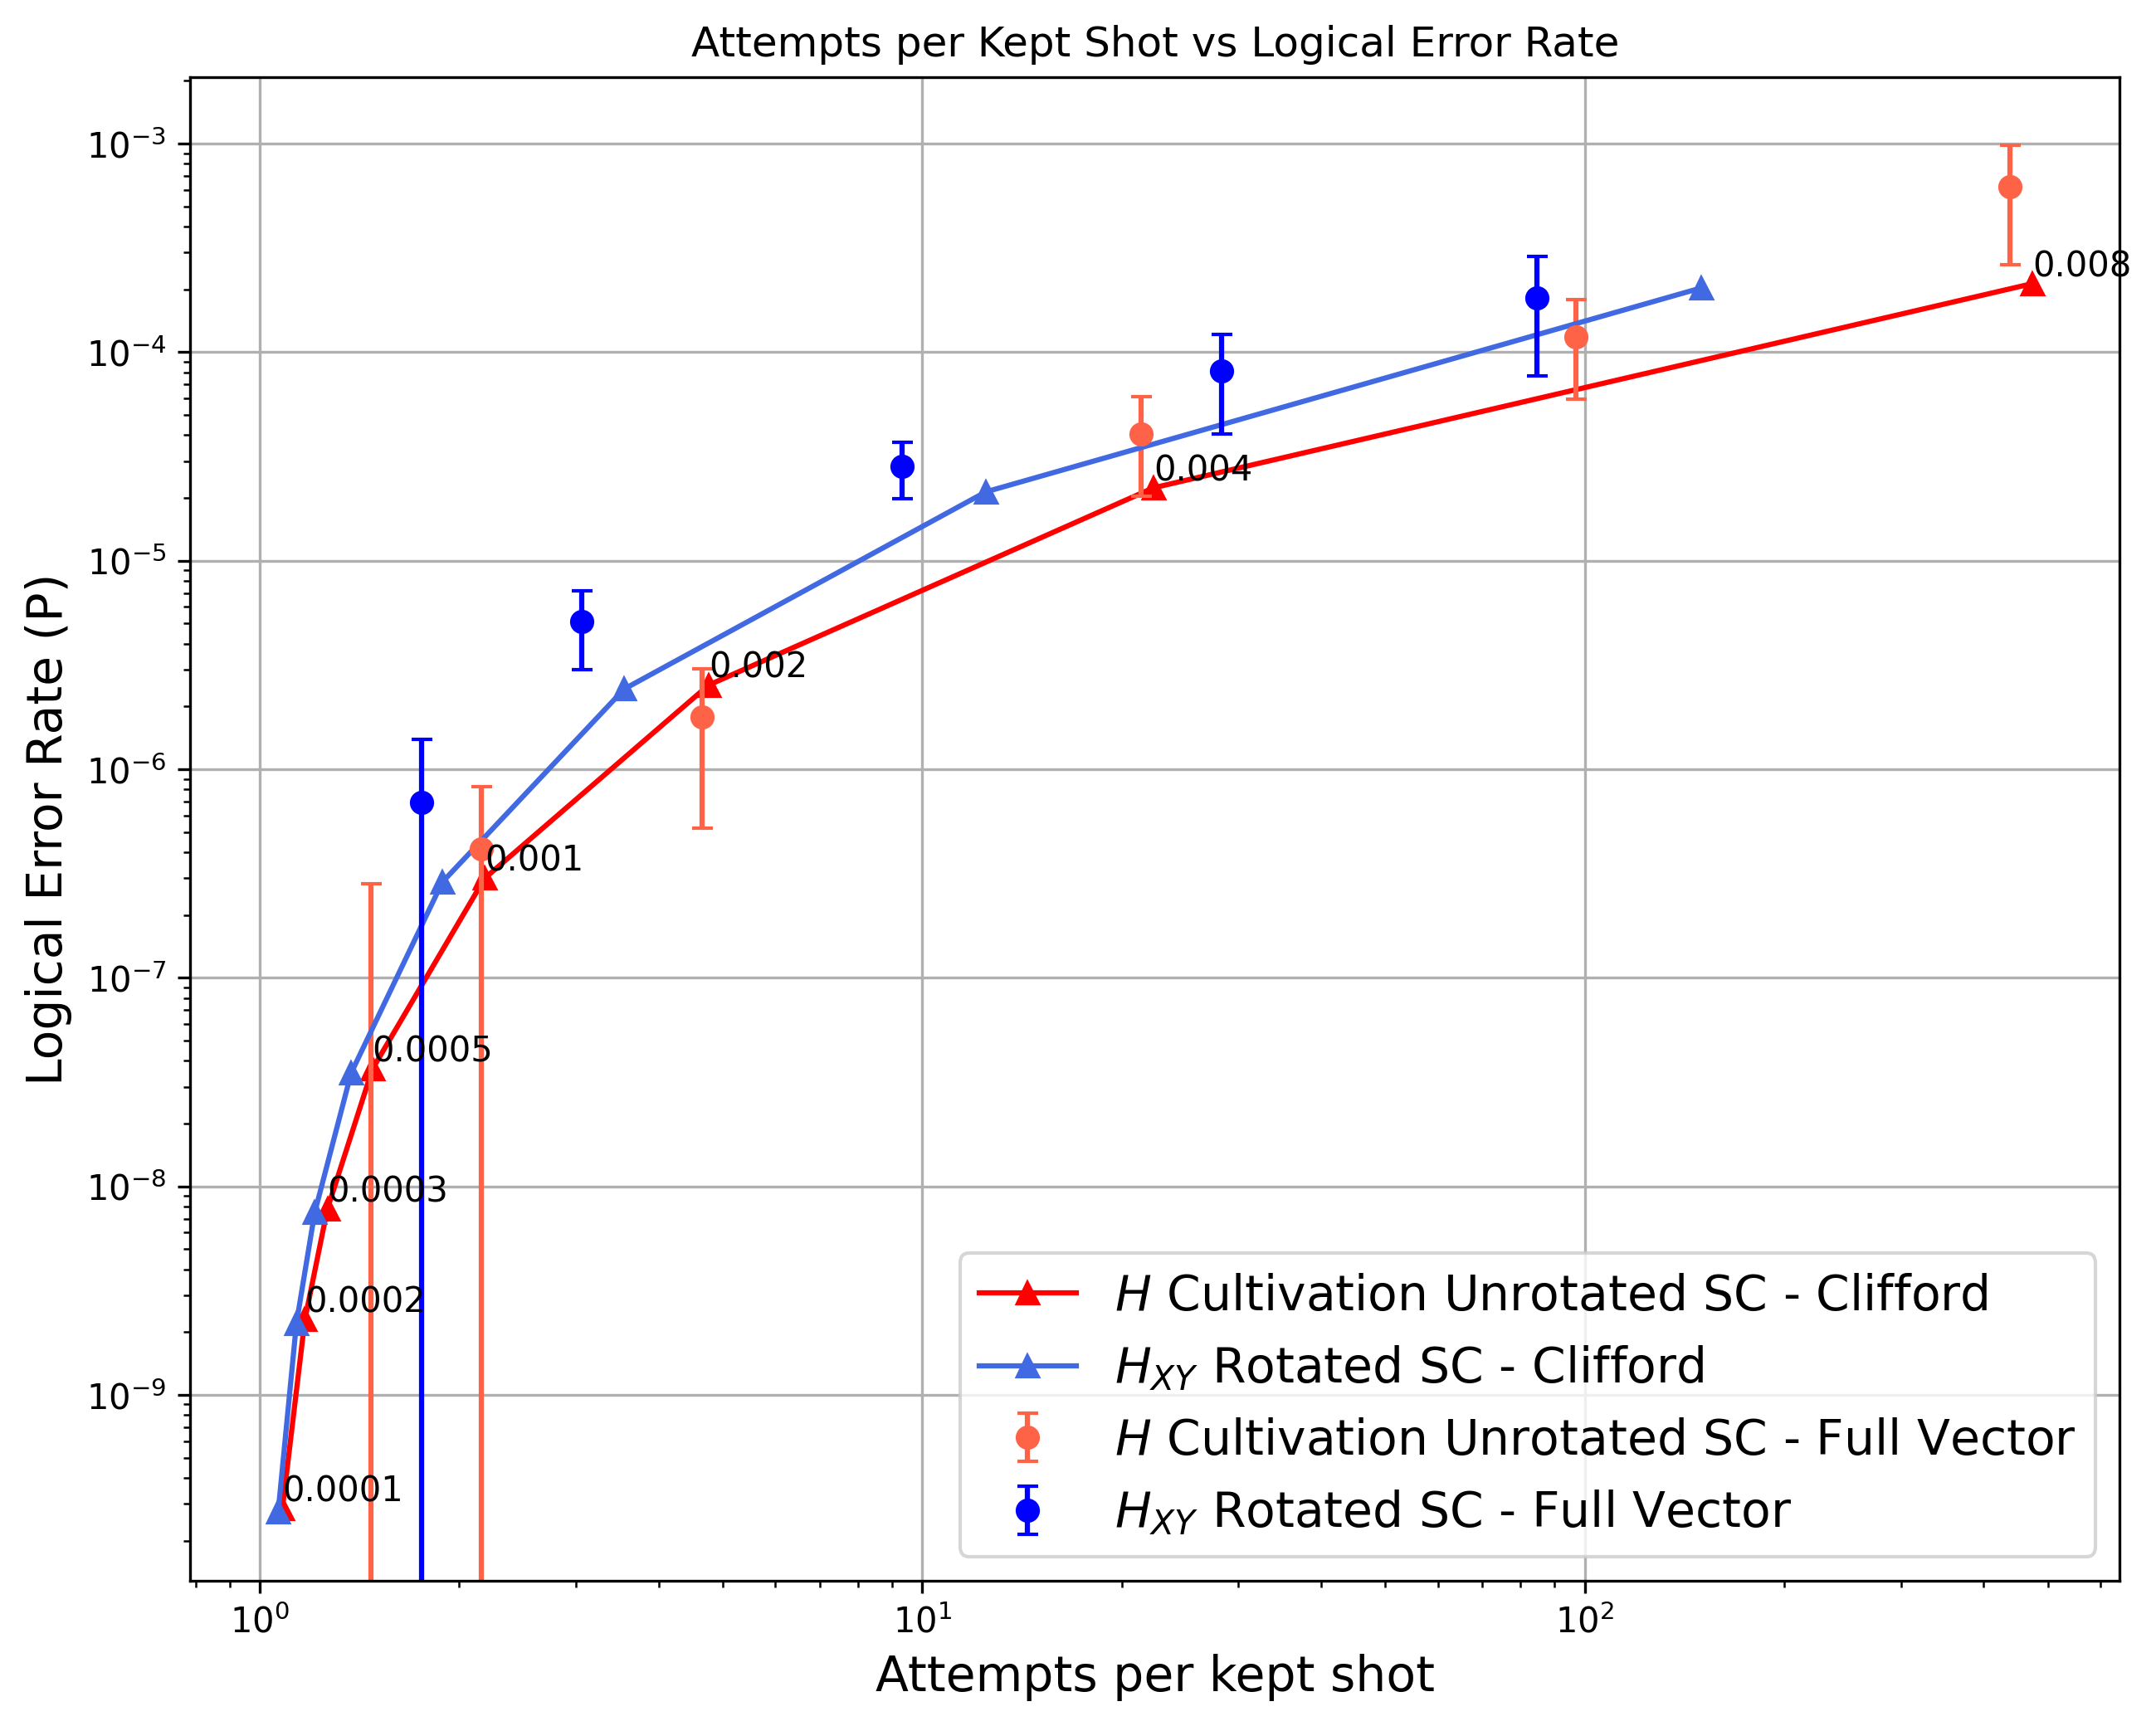

In [ ]:
df_full_vec = pd.read_csv("combined_vec_sim.csv")

fig, ax = plt.subplots(figsize=(10, 8), dpi = 300)
# Gidney d=3 and d=5
gidney_d3_circuit = stim.Circuit.from_file("../../2024/CX Cultivation/2024-gidney-circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=15,b=Y,r=4,d1=3.stim")
gidney_d5_circuit = stim.Circuit.from_file("../../2024/CX Cultivation/2024-gidney-circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=42,b=Y,r=10,d1=5.stim")
es = [0, 1e-3, 0.002]#, 0.004]
ps = [1e-4, 2e-4, 3e-4, 5e-4, 1e-3, 2e-3, 4e-3, 8e-3]
ps_labels = ["1e-4","2e-4","3e-4", "5e-4","1e-3","2e-3"]
mask3 = (df_gidney_d3.P > 0) & (df_gidney_d3.rate > 0)
mask5 = (df_gidney_d5.P > 0) & (df_gidney_d5.rate > 0)

markers = 'oX^<'
def plot(ax, x, y, fmt, color, label):
    ax.plot(x, y, fmt, label = label, color = color)
    for p_label, rate, fid in zip(ps_labels, x, y):
        ax.text(rate, fid, p_label, fontsize = 10)
    

plotted_error_rates = False
for circ_name, full_circ_name, label, color, vec_color in [
    ('init-H-injection-syndrome-ghz', 'unrotated_H_inj_double_correct','$H$ Cultivation Unrotated SC', 'red', 'tomato'), 
    ('init-HXY-rotated-init-x-injection-syndrome-double-ghz-HXY','rotated_HXY_injection_double_ghz', '$H_{XY}$ Rotated SC', 'royalblue', 'blue')]:
    ordered_ps, heralded_error_rates, keep_rates, e_rate, report= plot_circuit_type_using_report(circ_name, 0, ps = ps)
    ax.plot(keep_rates , heralded_error_rates , f'{m}-', label=f"{label} - Clifford", color = color) 
    if plotted_error_rates == False:
        for p, keep_rates, heralded_error_rates in zip(ordered_ps, keep_rates, heralded_error_rates):
            ax.text(keep_rates, heralded_error_rates, f"{p}", fontsize=10, ha='left', va='bottom')
        plotted_error_rates = True

    for idx, row in df_full_vec.iterrows():
        if not row['circuit'] == full_circ_name:
            continue
        if row['p'] == 4e-3:
            ax.errorbar(row['rate'], row['P'], yerr=row['dP'], fmt='o', color=vec_color, capsize=3, label = f"{label} - Full Vector" )
        else:
            ax.errorbar(row['rate'], row['P'], yerr=row['dP'], fmt='o', color=vec_color, capsize=3)
    # Plot text with row['p'] next to each point


ax.set_ylabel('Logical Error Rate (P)', fontsize = 14)
ax.set_xlabel('Attempts per kept shot', fontsize = 14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True)
ax.legend(loc = 'lower right', fontsize = 14)
ax.set_title('Attempts per Kept Shot vs Logical Error Rate')

plt.savefig('fig/full_vec_sim.pdf', dpi = 300)




In [211]:
!open fig